<div style="text-align: center;">
    <h1 style="font-size: 20px;">
        Final project for the <strong style="font-size: 26px;">Information theory </strong> course<br>
        <strong style="font-size: 46px; display: block; margin-top: 20px;">Inferring change points in the spread of COVID-19</strong>
    </h1>
</div>

<hr style="border: 1px solid #000;">

<div style="display: flex; justify-content: center; align-items: center; flex-wrap: wrap; gap: 20px;">
    <img src="figures/unipd_template.png" alt="Unipd template" style="max-width: 350px; height: auto; margin: 0;">
    <img src="figures/pod_template_transparent.png" alt="PoD template" style="max-width: 450px; height: auto; margin: 0;">
</div>

<hr style="border: 1px solid #000;">

<div style="text-align: left; margin: 0 auto; width: 80%;">
    <p><strong style="font-size: 26px;">University of Padua - Department of Physics and Astronomy</strong></p>
    <p><strong>Degree course:</strong> Physics of Data</p>
    <p><strong>Course:</strong> Information Theory </p>
    <p><strong>Year:</strong> 2024-2025</p>
    <p><strong>Professor in charge:</strong> Michele Allegra </p>
    <table style="margin: 20px auto; border-collapse: collapse; width: 100%; font-size: 15px; text-align: left;">
        <thead>
            <tr>
                <th colspan="3" style="border: none; padding: 8px; text-align: center; font-weight: bold; font-size: 20px">Students</th>
            </tr>
            <tr>
                <th style="border: none; padding: 8px;">Name</th>
                <th style="border: none; padding: 8px;">ID</th>
                <th style="border: none; padding: 8px;">Email</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <td style="border: none; padding: 8px;">Ada D'Iorio</td>
                <td style="border: none; padding: 8px;">2092320</td>
                <td style="border: none; padding: 8px;">ada.diorio@studenti.unipd.it</td>
            </tr>
            <tr>
                <td style="border: none; padding: 8px;">Anna Garbo</td>
                <td style="border: none; padding: 8px;">XXXXXXXX</td>
                <td style="border: none; padding: 8px;">anna.garbo.2@studenti.unipd.it</td>
            </tr>
        </tbody>
    </table>
</div>

# Basic SIR model (no switch and no delay) 

In this first section we are going to implement the basic SIR model structure, characterised by solving the system of differential equations:

$$
\begin{cases}
\frac{dS}{dt} = - \beta S I \\  
\frac{dI}{dt} = \beta S I - \gamma I \\  
\frac{dR}{dt} = \gamma I  
\end{cases}
$$

by integrating this system of equations it is possible to study the evolution of a pandemic.

In this basic model, the parameters that are going to be inferred are the *spreading rate* $\beta$, the recovery rate $\gamma$, the initial number of infected $I_0$ and the scale factor $\sigma$.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.stats as stats
import pymc as pm
import pytensor 
import pytensor.tensor as pt
import pandas as pd 
import arviz as az 
import multiprocessing
from datetime import datetime, timedelta 
from SIR_functions import metropolis_hastings, metropolis_hastings_multi_chain

In [ ]:
from SIR_functions import sir_discrete

# Parameters
N = 1e6 # population size 
t_max = 100
# Initial parameters for priors 
sigma_beta, mu_beta = 0.5, np.log(0.4) # initial value 0.5 for sigma
sigma_gamma, mu_gamma = 0.2, np.log(1/8) # \ \ 0.2 
sigma_I0 = 100
sigma_scale = 100 # 10 before 


## MCMC sampling

In order to solve the problem, we are going to use the **Markov Chain Monte Carlo** method. The aim is to build a chain that has as limiting distribution the posterior of all the parameters that have to be inferred in the model.
In the first part, we are going to construct from scratches the algorithm, defining the prior and likelihood distributions. For the seek of semplicity, we are going to define the **logprior** and **logposterior**. In this way, the final distribution will be obtained from the sum of all the parameters distributions indipendently.

In particular we have chosen to use the following distributions:

| Parameter         | Variable | Prior distribution                 |
|------------------|---------|-----------------------------------|
| Spreading rate  | \( $\lambda$ \) | LogNormal[log(0.4), 0.5]       |
| Recovery rate   | \( $\mu$ \)     | LogNormal[log(1/8), 0.2]       |
| Initially infected | \( $I_0$ \) | HalfCauchy(100)                |
| Scale factor    | \( $\sigma$ \)  | HalfCauchy(10)                 |

In order to stabilize the result, we are going to sample 20 MCMC chains and take as estimate for the result the mean of the inferred values from each chain. The standard deviation will be estimated too.

In [3]:
# Modello con le prior del paper 
def log_prior(beta, gamma, I0, scale):
    logp = (    
        stats.lognorm.logpdf(beta, s=sigma_beta, scale=np.exp(mu_beta)) +
        stats.lognorm.logpdf(gamma, s=sigma_gamma, scale=np.exp(mu_gamma)) +
        stats.halfcauchy.logpdf(I0, scale=sigma_I0) +
        stats.halfcauchy.logpdf(scale, scale=sigma_scale)
    )
    return logp

In [ ]:
def log_likelihood(params, data):
    beta, gamma, I0, scale = params
    I_pred = sir_discrete(beta, gamma, I0,scale, t_max, N)  # Solve SIR model with delay
    
    # Likelihood: Assume reported cases C_t follows Normal(C_pred, scale)
    return np.sum(stats.norm.logpdf(data, loc=I_pred, scale=scale))


In [5]:
# ---- LOG-POSTERIOR ----
def log_posterior(params, data):
    beta, gamma, I0, scale = params
    prior = log_prior(beta, gamma, I0, scale)
    if np.isinf(prior) or np.isnan(prior):
        return -np.inf  # Reject invalid samples
    return prior + log_likelihood(params, data)

In [ ]:
# ---- SIMULATE DATA ----
true_params = [0.4, 0.1, 100, 2]  # True values for beta, gamma, I0, scale
n_chains = 15
S0 = N - true_params[2]
y0 = [S0, true_params[2], 0]
t = np.linspace(0, 100, 100)
I_true = sir_discrete(*true_params, t_max, N) + np.random.normal(0, true_params[3], size=len(t))  # Add noise

# ---- RUN MCMC ----
initial_guess = [0.7, 0.05, 80, 1] 

initial_params_list = [
    initial_guess + np.random.normal(0, [0.02, 0.02, 10, 0.2], 4)
    for _ in range(n_chains)
]

step_sizes_list = [
    np.array([0.01, 0.02, 10, 0.05]) + np.random.uniform(-0.005, 0.005, 4)
    for _ in range(n_chains)
]

samples = metropolis_hastings_multi_chain(log_posterior, initial_params_list, step_sizes_list, I_true, n_iter=20000, n_chains=n_chains)

Running chain 1/15...


C:\Users\adadi\AppData\Local\Temp\ipykernel_33248\3784146824.py:14: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(logp_new - logp_old)


Running chain 2/15...
Running chain 3/15...
Running chain 4/15...
Running chain 5/15...
Running chain 6/15...
Running chain 7/15...
Running chain 8/15...
Running chain 9/15...
Running chain 10/15...
Running chain 11/15...
Running chain 12/15...
Running chain 13/15...
Running chain 14/15...
Running chain 15/15...
Lunghezze dei campioni: [20001, 20001, 20001, 20001, 20001, 20001, 20001, 20001, 20001, 20001, 20001, 20001, 20001, 20001, 20001]


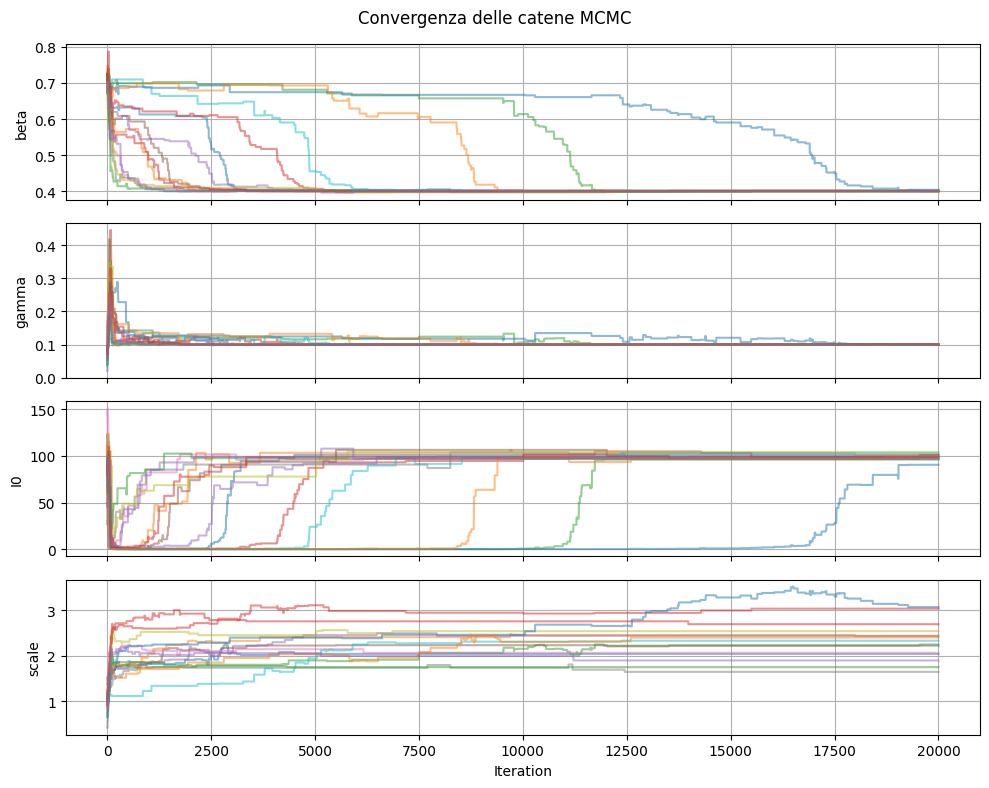

In [74]:
param_names = ["beta", "gamma", "I0", "scale"]

fig, axes = plt.subplots(len(param_names), 1, figsize=(10, 2 * len(param_names)), sharex=True)

for i, ax in enumerate(axes):
    for chain in samples:
        ax.plot(chain[:, i], alpha=0.5)
    ax.set_ylabel(param_names[i])
    ax.grid()

axes[-1].set_xlabel("Iteration")
plt.suptitle("Convergenza delle catene MCMC")
plt.tight_layout()
plt.show()

🔍 Parametri Verità:
  Beta1: 0.4000, Gamma: 0.1000, I0: 100, Scale: 2

🔍 Parametri Inferiti:
  beta: 0.4007 ± 0.0012
  gamma: 0.1001 ± 0.0002
  I0: 98.5939 ± 3.2728
  scale: 2.3166 ± 0.4031


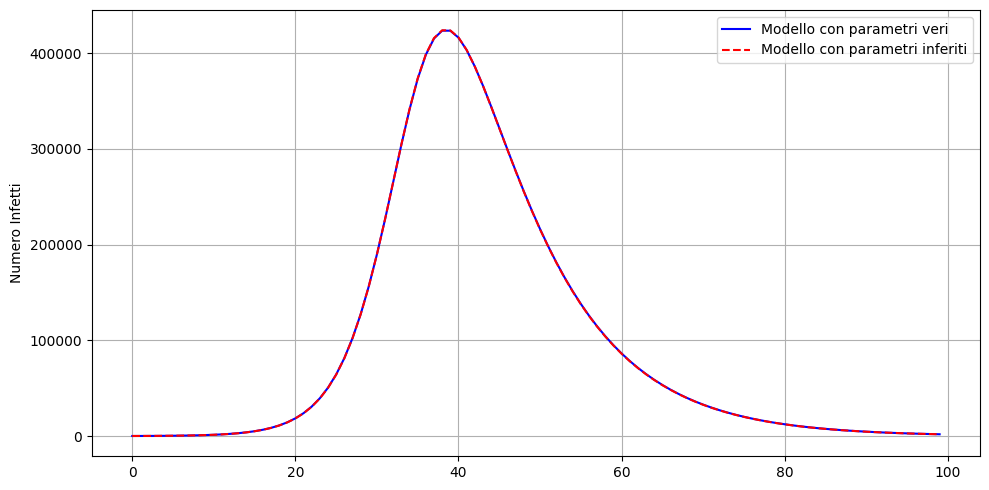

In [ ]:
burn_in = 1000
mean_estimates = np.mean(samples[:, -burn_in:, :], axis=(0, 1))
std_estimates = np.std(samples[:, -burn_in:, :], axis=(0, 1))

beta_sampled, gamma_sampled, I0_sampled, scale_sampled = mean_estimates

print("🔍 Parametri Verità:")
print(f"  Beta1: {true_params[0]:.4f}, Gamma: {true_params[1]:.4f}, I0: {true_params[2]}, Scale: {true_params[3]}")

print("\n🔍 Parametri Inferiti:")
for name, mean, std in zip(param_names, mean_estimates, std_estimates):
    print(f"  {name}: {mean:.4f} ± {std:.4f}")
    
# ---- GENERIAMO LE DUE SIMULAZIONI ----
I_true_model = sir_discrete(*true_params, t_max, N)
I_sampled_model = sir_discrete(beta_sampled, gamma_sampled, I0_sampled, scale_sampled, t_max, N)

# ---- PLOT CONFRONTO ----
figure = plt.figure(figsize = (10, 5))
# Plot Infected Cases
plt.plot(I_true_model, label="Modello con parametri veri", color="blue")
plt.plot(I_sampled_model, label="Modello con parametri inferiti", color="red", linestyle="dashed")
plt.ylabel("Numero Infetti")
plt.legend()
plt.grid()

fig.suptitle("📊 Confronto tra modello con parametri veri e inferiti")
plt.tight_layout()
plt.show()

As we can observe, the final values are compatible with the true values. Also, the inferred model is following the theoretical one in a significant way.

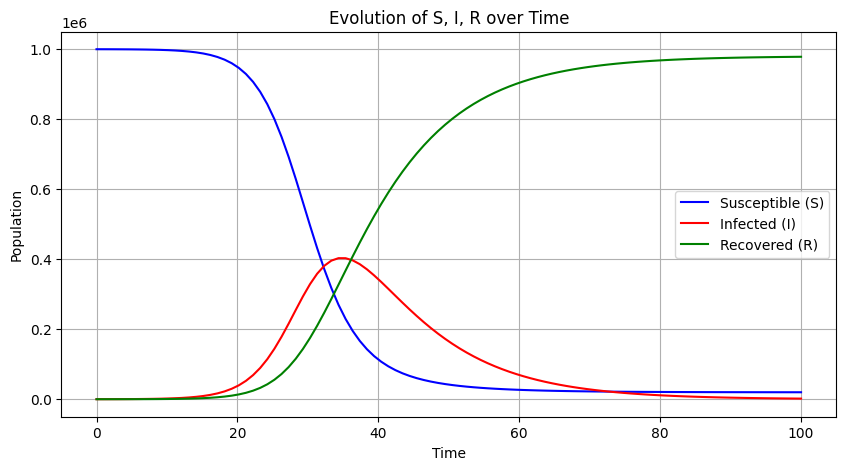

In [76]:
# Basic sir model, just for the plot 
def sir_model(y, t, beta, gamma):
    S, I, R = y
    # Change beta after day 50 - switching point
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]


# ---- SOLVE SIR MODEL USING ESTIMATED PARAMETERS ----
S0_est = N - I0_sampled
y0_est = [S0_est, I0_sampled, 0]  # Initial conditions

sol_est = odeint(sir_model, y0_est, t, args=(beta_sampled, gamma_sampled))
S_est, I_est, R_est = sol_est[:, 0], sol_est[:, 1], sol_est[:, 2]

# ---- PLOT THE EVOLUTION OF S, I, R ----
plt.figure(figsize=(10, 5))
plt.plot(t, S_est, label="Susceptible (S)", color="blue")
plt.plot(t, I_est, label="Infected (I)", color="red")
plt.plot(t, R_est, label="Recovered (R)", color="green")

plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Evolution of S, I, R over Time")
plt.legend()
plt.grid()
plt.show()

## MCMC sampling using PYMC

In this subsection, we have solved the problem using the **PYMC** library. It is a Python library for Bayesian inference, using Markov Chain Monte Carlo sampling to estimate posterior probability distributions in complex statistical models.
PyMC uses **No-U-Turn-Sampler (NUTS)** to generate samples from the posterior distribution. This allows estimating parameters and their uncertainties based on the data.

c:\ProgramData\anaconda3\lib\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.

Output()

Sampling 10 chains for 1_000 tune and 4_000 draw iterations (10_000 + 40_000 draws total) took 324 seconds.


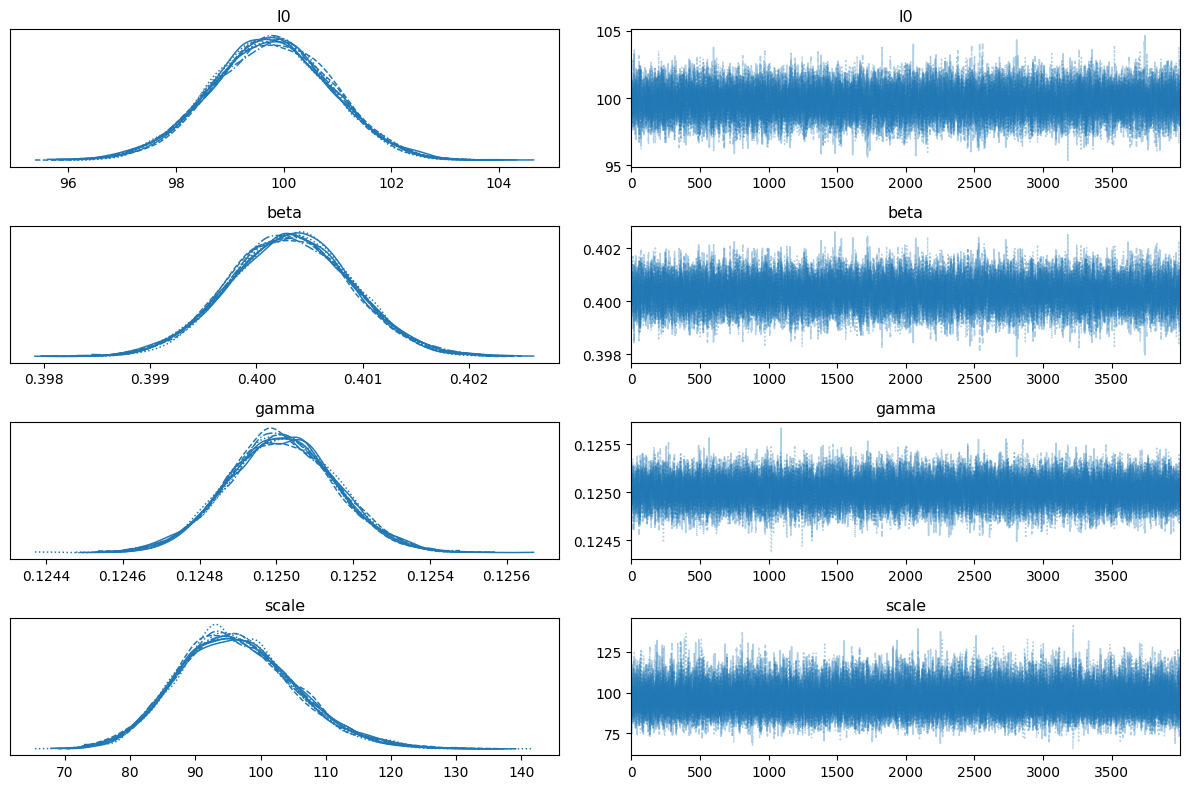

In [ ]:
def sir_model_pytensor(beta, gamma, N, I0, t):
    
    def step(_, S, I, R, beta, gamma, N):
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        S_new = S + dSdt
        I_new = I + dIdt
        R_new = R + dRdt
        return S_new, I_new, R_new

    S0 = pt.cast(N - I0, "float64")  
    R0 = pt.cast(0, "float64")  
    I0 = pt.cast(I0, "float64")  

    outputs, _ = pytensor.scan(fn=step, sequences=t, outputs_info=[S0, I0, R0], non_sequences=[beta, gamma, N])
    
    return outputs[1]  

# ---- SIMULATE DATA ----
true_params = [0.4, 1/8, 100, 100]  
N = 1e5
t = np.linspace(0, 100, 100)  

# ---- TEST CON PARAMETRI VERI ----
beta_true, gamma_true, I0_true, scale_true = true_params
t_t = pt.as_tensor_variable(t)

# Convertiamo in PyTensor
beta_t = pt.as_tensor_variable(beta_true)
gamma_t = pt.as_tensor_variable(gamma_true)
I0_t = pt.as_tensor_variable(I0_true)

# Eseguiamo il modello una sola volta con i parametri veri
I_test = sir_model_pytensor(beta_t, gamma_t, N, I0_t, t_t)

# Compiliamo ed eseguiamo il calcolo con PyTensor
f = pytensor.function([], I_test)
I_true = f()
df_t = 4  
I_obs = I_true + stats.t.rvs(df=df_t, loc=0, scale=true_params[3], size=len(t))

# ---- BAYESIAN MODEL ----
with pm.Model() as model:
    # Priors
    beta = pm.Lognormal("beta", mu=np.log(0.4), sigma=0.5)
    gamma = pm.Lognormal("gamma", mu=np.log(1/8), sigma=0.2)
    I0 = pm.HalfCauchy("I0", beta=200)
    scale = pm.HalfCauchy("scale", beta=10)

    # Convertiamo le variabili in tensori `PyTensor`
    beta_t = pt.as_tensor_variable(beta)
    gamma_t = pt.as_tensor_variable(gamma)
    I0_t = pt.as_tensor_variable(I0)
    t_t = pt.as_tensor_variable(t)

    # SIR model in PyTensor
    I_pred =  sir_model_pytensor(beta_t, gamma_t, N, I0_t, t_t)

    # Likelihood (data model)
    pm.StudentT("obs", nu=4, mu=I_pred, sigma=scale, observed=I_obs)

    # Sampling
    trace = pm.sample(4000, tune=1000, cores=10, return_inferencedata=True, target_accept=0.9)

# ---- PLOT RESULTS ----
pm.plot_trace(trace)
plt.tight_layout()
plt.show()


In [4]:
# Genera il summary
summary = az.summary(trace)

summary

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
I0     99.763  1.109  97.716  101.892      0.010    0.007   12064.0   16607.0   
beta    0.400  0.001   0.399    0.401      0.000    0.000   11506.0   15660.0   
gamma   0.125  0.000   0.125    0.125      0.000    0.000   14130.0   19504.0   
scale  96.331  9.004  79.677  113.274      0.058    0.041   23860.0   22233.0   

       r_hat  
I0       1.0  
beta     1.0  
gamma    1.0  
scale    1.0

As in the previous case, the inferred values are compatible with the theoretical one.

# SIR model with delay introduction (no switches)

The same model structure is employed also in this case. The main difference is the introduction of the **delay** parameter, that is actually representing the reporting delay between the new infections and the newly reported cases. The parameters that are going to be used are:

| Parameter         | Variable | Prior distribution                 |
|------------------|---------|-----------------------------------|
| Spreading rate  | \( $\lambda$ \) | LogNormal[log(0.4), 0.5]       |
| Recovery rate   | \( $\mu$ \)     | LogNormal[log(1/8), 0.2]       |
| Reporting delay | \( D \)       | LogNormal[log(8), 0.2]         |
| Initially infected | \( $I_0$ \) | HalfCauchy(100)                |
| Scale factor    | \( $\sigma$ \)  | HalfCauchy(10)                 |


In [3]:
from SIR_functions import sir_discrete_delay_no_switch

# ---- PARAMETERS ----
N = 1e6  # Population size
t_max = 100  # Total days of simulation
# Priors
N = 1e6
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_gamma, mu_gamma = 0.2, np.log(1/8)
sigma_delay, mu_delay = 0.2, np.log(8)
sigma_I0 = 100
sigma_scale = 10

# ---- PRIOR FUNCTION ----
def log_prior(beta, gamma, delay, I0, scale):
    logp = (
        stats.lognorm.logpdf(beta, s=0.5, scale=np.exp(np.log(0.4))) +
        stats.lognorm.logpdf(gamma, s=0.2, scale=np.exp(np.log(1/8))) +
        stats.lognorm.logpdf(delay, s=0.2, scale=np.exp(np.log(8))) +
        stats.halfcauchy.logpdf(I0, scale=100) +
        stats.halfcauchy.logpdf(scale, scale=10)
    )
    return logp

# ---- LOG-LIKELIHOOD ----
def log_likelihood(params, data):
    beta, gamma, delay, I0, scale = params
    I_pred, C_pred = sir_discrete_delay_no_switch(beta, gamma, delay, I0, scale, t_max, N)  # Solve SIR model with delay
    
    # Likelihood: Assume reported cases C_t follows Normal(C_pred, scale)
    return np.sum(stats.norm.logpdf(data, loc=C_pred, scale=scale))

# ---- LOG-POSTERIOR ----
def log_posterior(params, data):
    beta, gamma, delay, I0, scale = params
    prior = log_prior(beta, gamma, delay, I0, scale)
    if np.isinf(prior) or np.isnan(prior):
        return -np.inf  # Reject invalid samples
    return prior + log_likelihood(params, data)

n_chains = 15 
# ---- SIMULATE DATA ----
true_params = [0.4, 1/8, 8, 100, 2]  # True values for beta, gamma, delay, I0, scale
I_true, C_true = sir_discrete_delay_no_switch(*true_params, t_max, N)  # Generate true epidemic curve
C_true += np.random.normal(0, true_params[4], size=t_max)  # Add noise

# ---- RUN MCMC ----
initial_guess = [0.8, 0.05, 5, 100, 1.5]  # Initial parameter guess

initial_params_list = [
    initial_guess + np.random.normal(0, [0.02, 0.02, 2, 2, 0.2], 5)
    for _ in range(n_chains)
]

step_sizes_list = [
    np.array([0.01, 0.02, 2, 1, 0.05]) + np.random.uniform(-0.005, 0.005, 5)
    for _ in range(n_chains)
]

samples = metropolis_hastings_multi_chain(log_posterior, initial_params_list, step_sizes_list, C_true, n_iter=20000, n_chains=n_chains)


Running chain 1/15...


c:\Users\adadi\OneDrive\Desktop\IT_project\SIR_functions.py:241: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(logp_new - logp_old)


Running chain 2/15...
Running chain 3/15...
Running chain 4/15...
Running chain 5/15...
Running chain 6/15...
Running chain 7/15...
Running chain 8/15...
Running chain 9/15...
Running chain 10/15...
Running chain 11/15...
Running chain 12/15...
Running chain 13/15...
Running chain 14/15...
Running chain 15/15...


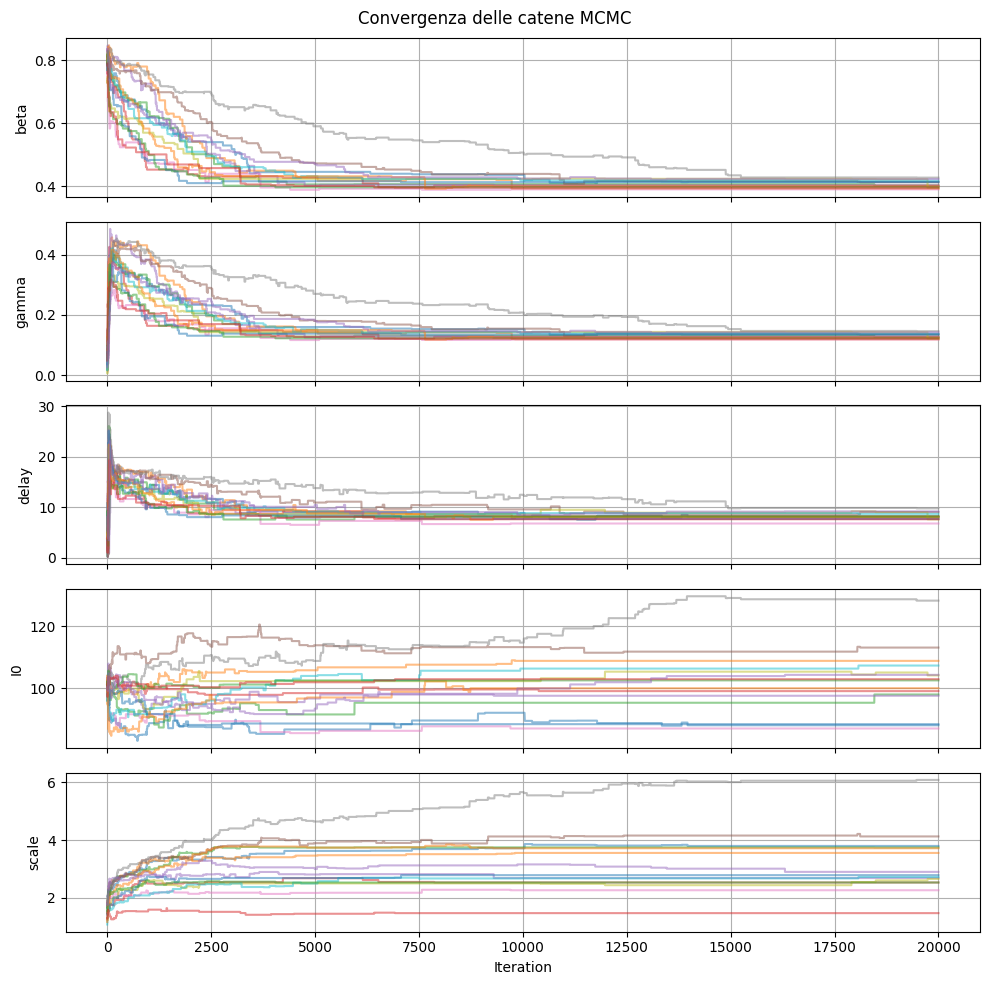

In [41]:
# ---- PLOT RESULTS IN SUBPLOTS ----
param_names = ["beta", "gamma", "delay", "I0", "scale"]
fig, axes = plt.subplots(len(param_names), 1, figsize=(10, 2 * len(param_names)), sharex=True)

for i, ax in enumerate(axes):
    for chain in samples:
        ax.plot(chain[:, i], alpha=0.5)
    ax.set_ylabel(param_names[i])
    ax.grid()

axes[-1].set_xlabel("Iteration")
plt.suptitle("Convergenza delle catene MCMC")
plt.tight_layout()
plt.show()

🔍 Parametri Verità:
  Beta1: 0.4000, Gamma: 0.1250, delay: 8, I0: 100, Scale: 2

🔍 Parametri Inferiti:
  beta: 0.4067 ± 0.0115
  gamma: 0.1299 ± 0.0086
  delay: 8.2558 ± 0.7277
  I0: 102.0427 ± 10.1796
  scale: 3.1712 ± 1.0323


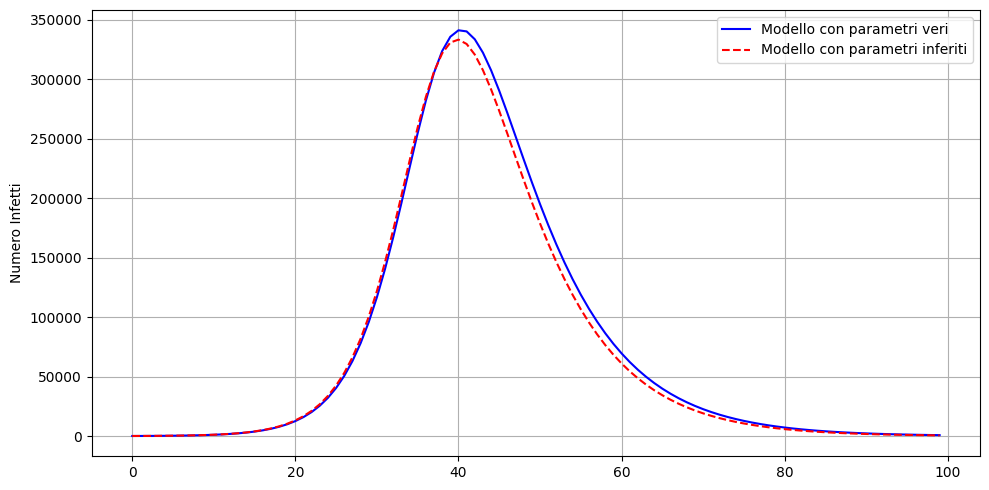

In [ ]:
burn_in = 1000
mean_estimates = np.mean(samples[:, -burn_in:, :], axis=(0, 1))
std_estimates = np.std(samples[:, -burn_in:, :], axis=(0, 1))

beta_sampled, gamma_sampled, delay_sampled, I0_sampled, scale_sampled = mean_estimates

print("🔍 Parametri Verità:")
print(f"  Beta1: {true_params[0]:.4f}, Gamma: {true_params[1]:.4f}, delay: {true_params[2]}, I0: {true_params[3]}, Scale: {true_params[4]}")

print("\n🔍 Parametri Inferiti:")
for name, mean, std in zip(param_names, mean_estimates, std_estimates):
    print(f"  {name}: {mean:.4f} ± {std:.4f}")
    
# ---- GENERIAMO LE DUE SIMULAZIONI ----
I_true_model, C_true_model = sir_discrete_delay_no_switch(*true_params, t_max, N)
I_sampled_model, C_sampled_model = sir_discrete_delay_no_switch(beta_sampled, gamma_sampled, delay_sampled, I0_sampled, scale_sampled, t_max, N)

# ---- PLOT CONFRONTO ----
figure = plt.figure(figsize = (10, 5))
# Plot Infected Cases
plt.plot(I_true_model, label="Modello con parametri veri", color="blue")
plt.plot(I_sampled_model, label="Modello con parametri inferiti", color="red", linestyle="dashed")
plt.ylabel("Numero Infetti")
plt.legend()
plt.grid()

fig.suptitle("📊 Confronto tra modello con parametri veri e inferiti")
plt.tight_layout()
plt.show()

The delay is actually introducing some noise in the model, making the prediction for the algorithm harder.

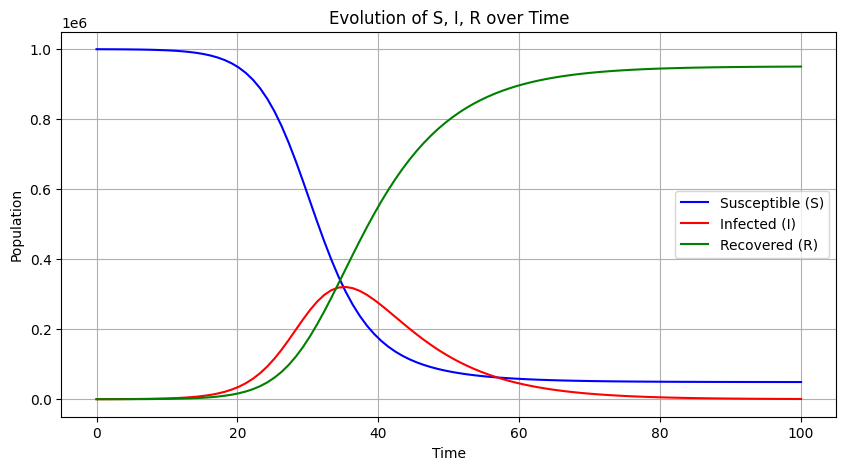

In [82]:
# Basic sir model, just for the plot 
def sir_model(y, t, beta, gamma, delay, N):
    S, I, R = y
    
    # Introduce delay in transmission using a past infection value
    delayed_t = max(0, t - delay)
    delayed_I = I if delayed_t == 0 else I  # Placeholder, ODE solvers don't natively support history
    
    # Compute new infections and recoveries
    dSdt = -beta * S * delayed_I / N
    dIdt = beta * S * delayed_I / N - gamma * I
    dRdt = gamma * I
    
    return [dSdt, dIdt, dRdt]


# ---- SOLVE SIR MODEL USING ESTIMATED PARAMETERS ----
S0_est = N - I0_sampled
y0_est = [S0_est, I0_sampled, 0]  # Initial conditions

sol_est = odeint(sir_model, y0_est, t, args=(beta_sampled, gamma_sampled, delay_sampled, N))
S_est, I_est, R_est = sol_est[:, 0], sol_est[:, 1], sol_est[:, 2]

# ---- PLOT THE EVOLUTION OF S, I, R ----
plt.figure(figsize=(10, 5))
plt.plot(t, S_est, label="Susceptible (S)", color="blue")
plt.plot(t, I_est, label="Infected (I)", color="red")
plt.plot(t, R_est, label="Recovered (R)", color="green")

plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Evolution of S, I, R over Time")
plt.legend()
plt.grid()
plt.show()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, gamma, I0, delay, scale_delay, scale]


Output()

Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 4942 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


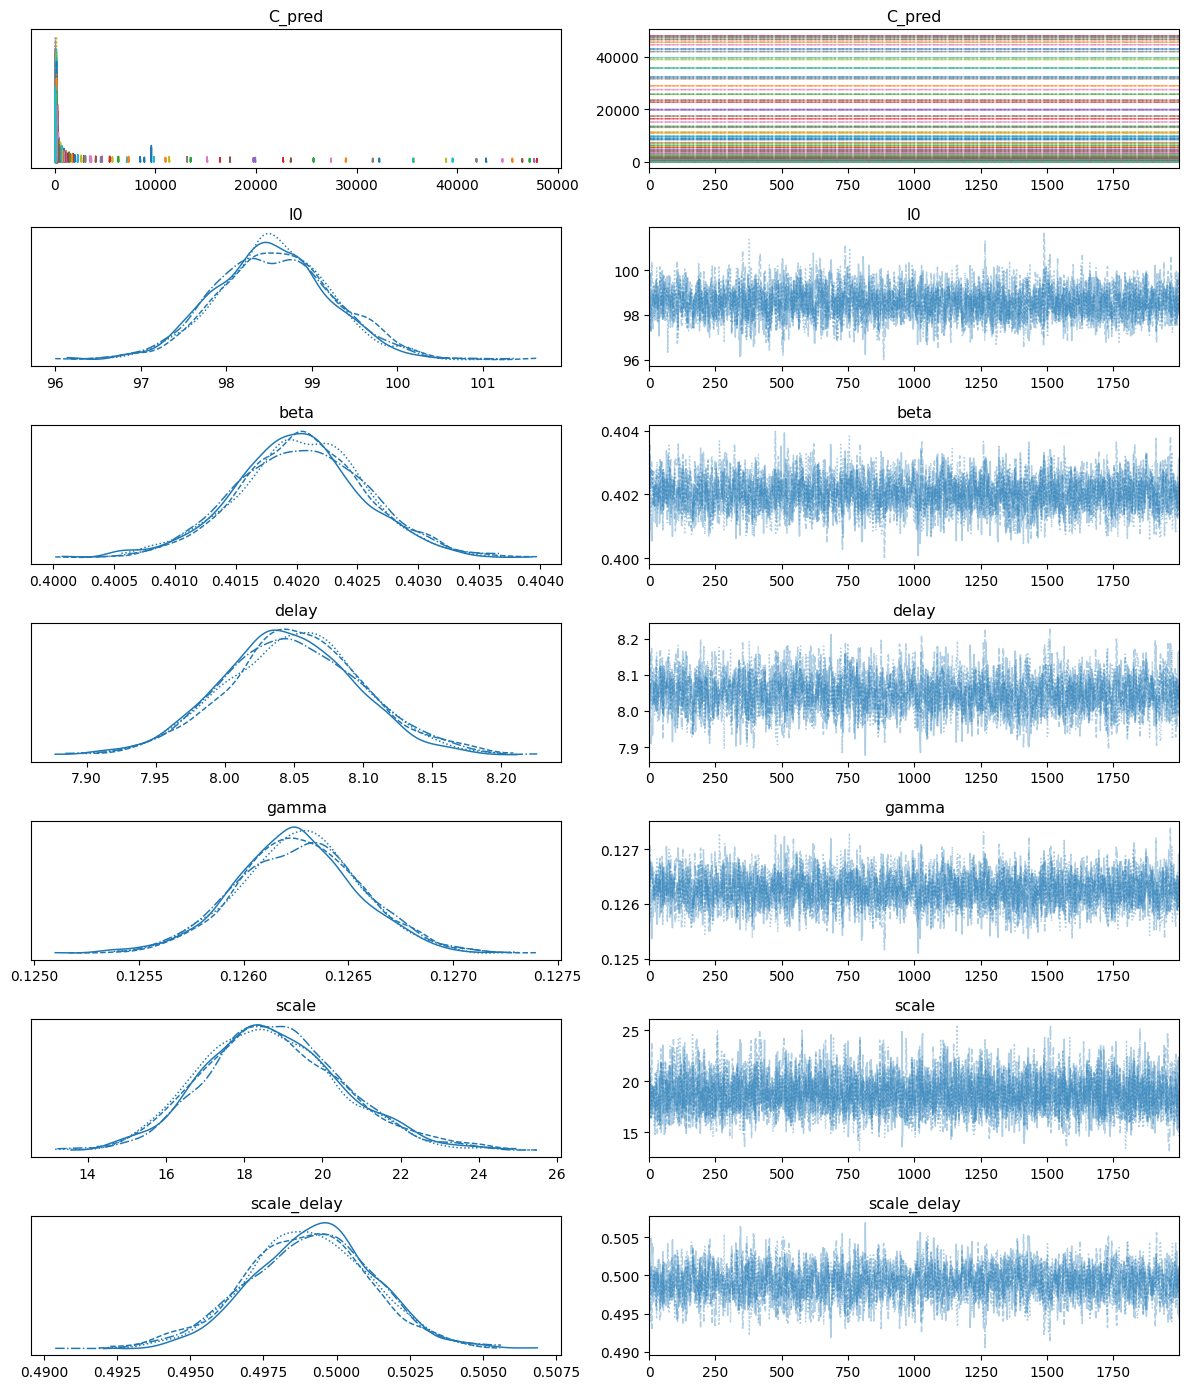

In [5]:
from SIR_functions import pt_lognormal, make_delay_matrix, apply_delay, delay_cases_lognormal 

# ---- SIR MODEL ----
def sir_model_pytensor(beta, gamma, N, I0, t_max):

    def step(_, S, I, R, I_new, beta, gamma, N):
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        S_new = S + dSdt
        I_new = I + dIdt
        R_new = R + dRdt
        return S_new, I_new, R_new, -dSdt

    S0 = pt.cast(N - I0, "float64")
    R0 = pt.cast(0, "float64")
    I0 = pt.cast(I0, "float64")
    I_new0 = pt.cast(0, "float64")

    outputs, _ = pytensor.scan(fn=step, sequences=pt.arange(t_max),
                               outputs_info=[S0, I0, R0, I_new0],
                               non_sequences=[beta, gamma, N])

    return outputs[3]  # nuovi infetti giornalieri


# ---- SIMULAZIONE DATI ----
true_params = {"beta": 0.4, "gamma": 1/8, "I0": 100, "scale": 10, "delay": 8, "scale_delay": 0.5}
N = 1e6
t_max = 100

# SIR deterministico
I_new_true = sir_model_pytensor(true_params["beta"], true_params["gamma"], N, true_params["I0"], t_max)
f = pytensor.function([], [I_new_true])
I_new_true = f()[0]

# Ritardo osservativo lognormale
lognorm_kernel_sim = stats.lognorm.pdf(make_delay_matrix(t_max, t_max), s=true_params["scale_delay"], scale=true_params["delay"])
lognorm_kernel_sim /= lognorm_kernel_sim.sum(axis=1, keepdims=True)
C_obs = np.dot(I_new_true, lognorm_kernel_sim)

# Rumore osservativo t-Student
C_obs += stats.t.rvs(df=5, loc=0, scale=true_params["scale"], size=len(C_obs))

# ---- MODELLO BAYESIANO PyMC ----
with pm.Model() as model:
    beta = pm.Lognormal("beta", mu=np.log(0.4), sigma=0.5)
    gamma = pm.Lognormal("gamma", mu=np.log(1/8), sigma=0.2)
    I0 = pm.HalfCauchy("I0", beta=100)
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.5)
    scale_delay = pm.HalfNormal("scale_delay", sigma=1)

    I_new_pred = sir_model_pytensor(beta, gamma, N, I0, t_max)
    C_pred = pm.Deterministic("C_pred", delay_cases_lognormal(I_new_pred, t_max, t_max, delay, scale_delay))

    scale = pm.HalfCauchy("scale", beta=10)
    pm.StudentT("obs", nu=5, mu=C_pred, sigma=scale, observed=C_obs)

    trace = pm.sample(2000, tune=500, cores=4, target_accept=0.9)

az.plot_trace(trace)
plt.tight_layout()
plt.show()




In [8]:
summary = az.summary(trace)

print(summary.tail(6))

               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
I0           98.561  0.683  97.286   99.831      0.014    0.010    2459.0   
beta          0.402  0.001   0.401    0.403      0.000    0.000    2363.0   
delay         8.049  0.050   7.953    8.142      0.001    0.001    1919.0   
gamma         0.126  0.000   0.126    0.127      0.000    0.000    2470.0   
scale        18.750  1.794  15.383   22.075      0.030    0.021    3645.0   
scale_delay   0.499  0.002   0.495    0.503      0.000    0.000    1955.0   

             ess_tail  r_hat  
I0             2772.0    1.0  
beta           2590.0    1.0  
delay          2548.0    1.0  
gamma          2842.0    1.0  
scale          3560.0    1.0  
scale_delay    2550.0    1.0  


# SIR model with one switch

We are going to assume now that the spreading rate $\beta$ may change at ceratin time points $t_i$ from $\beta_{i-1}$ to $\beta_b$ linearly over a time window of $\Delta t_i$ days. In this way, we are taking into account for mitigation measures applied to contrast the spreading of the pandemic, such as the closing of markets and public spaces.

The new model will be characterized by:

| Parameter          | Variable   | Prior distribution              |
|-------------------|-----------|--------------------------------|
| Change point      | \( $t_1$ \)  | Normal(2020/03/09, 3)         |
| Change duration   | \( $\Delta t$ \) | LogNormal(log(3), 0.3)   |
| Spreading rates   | \( $\beta_0$ \) | LogNormal(log(0.4), 0.5)  |
|                   | \( $\beta_1$ \) | LogNormal(log(0.2), 0.5)  |
| Recovery rate     | \( $\gamma$ \)  | LogNormal(log(1/8), 0.2)     |
| Initially infected | \( $I_0$ \)  | HalfCauchy(100)               |
| Scale factor      | \( $\sigma$ \)  | HalfCauchy(10)                |

In this first case, the reporting delay will be omitted.


In [2]:
# ---- LOG-POSTERIOR ----
def log_posterior(params, data):
    beta_before, beta_after, gamma, I0, scale = params
    prior = log_prior(beta_before, beta_after, gamma, I0, scale)
    if np.isinf(prior) or np.isnan(prior):
        return -np.inf  # Reject invalid samples
    return prior + log_likelihood(params, data)

Running chain 1/20...


c:\Users\adadi\OneDrive\Desktop\IT_project\SIR_functions.py:241: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(logp_new - logp_old)


Running chain 2/20...
Running chain 3/20...
Running chain 4/20...
Running chain 5/20...
Running chain 6/20...
Running chain 7/20...
Running chain 8/20...
Running chain 9/20...
Running chain 10/20...
Running chain 11/20...
Running chain 12/20...
Running chain 13/20...
Running chain 14/20...
Running chain 15/20...
Running chain 16/20...
Running chain 17/20...
Running chain 18/20...
Running chain 19/20...
Running chain 20/20...


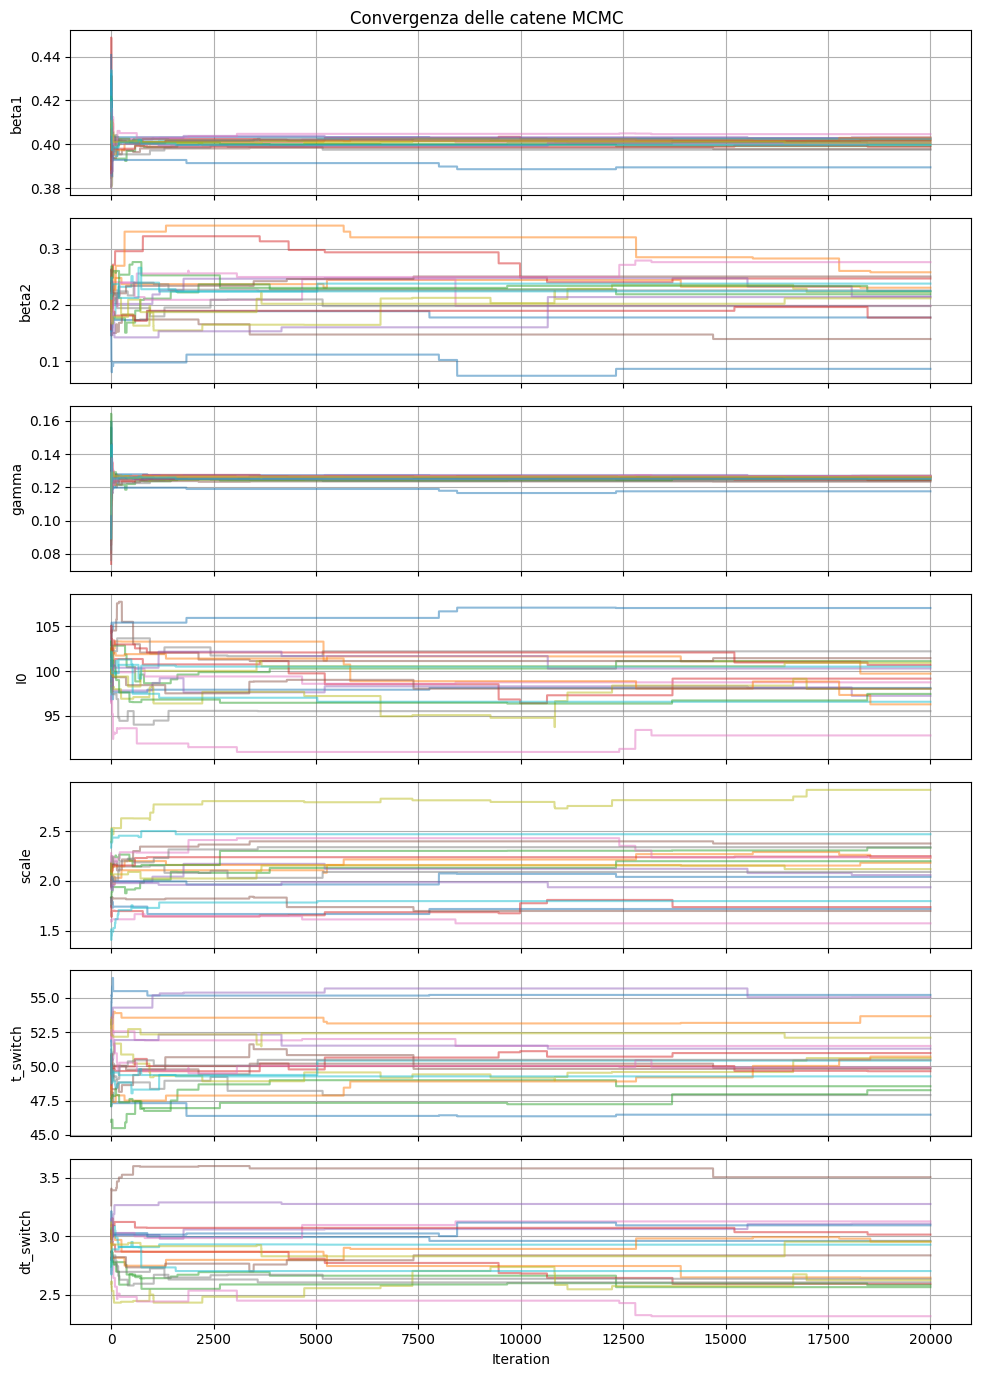

In [9]:
from SIR_functions import sir_discrete_single_switch 

# Parameters
N = 1e6 # population size 
t = np.linspace(0, 100, 100) # time grid 
t_max = 100
beta_before, beta_after = 0.4, 0.2

# Initial parameters for priors 
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_beta_2, mu_beta_2 = 0.5, np.log(0.2)
sigma_gamma, mu_gamma = 0.2, np.log(1/8) # \ \ 0.2 
sigma_I0 = 100
sigma_scale = 10
sigma_t, mu_t =  3, 50
sigma_dt, mu_dt = 0.3, np.log(3)

# Modello con le prior del paper 
def log_prior(beta_before, beta_after, gamma, I0, scale, t_switch, dt_switch):
    logp = (    
        stats.lognorm.logpdf(beta_before, s=sigma_beta, scale=np.exp(mu_beta)) +
        stats.lognorm.logpdf(beta_after, s=sigma_beta_2, scale=np.exp(mu_beta_2)) +
        stats.lognorm.logpdf(gamma, s=sigma_gamma, scale=np.exp(mu_gamma)) +
        stats.halfcauchy.logpdf(I0, scale=sigma_I0) +
        stats.halfcauchy.logpdf(scale, scale=sigma_scale) +
        stats.norm.logpdf(t_switch, loc=mu_t, scale=sigma_t) +
        stats.lognorm.logpdf(dt_switch, s = sigma_dt, scale = np.exp(mu_dt))
    )
    return logp

# ---- LOG-LIKELIHOOD ----
def log_likelihood(params, data):
    beta_before, beta_after, gamma, I0, scale, t_switch, dt_switch = params
    I_pred = sir_discrete_single_switch(beta_before, beta_after, gamma, I0, scale, t_switch, dt_switch, t_max, N)  # Solve SIR model with delay
    
    # Likelihood: Assume reported cases C_t follows Normal(C_pred, scale)
    return np.sum(stats.norm.logpdf(data, loc=I_pred, scale=scale))

# ---- LOG-POSTERIOR ----
def log_posterior(params, data):
    beta_before, beta_after, gamma, I0, scale, t_switch, dt_switch = params
    prior = log_prior(beta_before, beta_after, gamma, I0, scale, t_switch, dt_switch)
    if np.isinf(prior) or np.isnan(prior):
        return -np.inf  # Reject invalid samples
    return prior + log_likelihood(params, data)

# ---- MCMC (Metropolis-Hastings) ----
def metropolis_hastings(log_posterior, initial_params, data, n_iter=5000, step_sizes=None):
    params = np.array(initial_params)
    samples = [params]
    if step_sizes is None:
        step_sizes = np.array([0.01, 0.05, 0.05, 10, 0.05, 0.5, 0.05])  # Larger step for delay and I0
    
    for _ in range(n_iter):
        proposal = params + np.random.normal(0, step_sizes, size=len(params))
        
        logp_old = log_posterior(params, data)
        logp_new = log_posterior(proposal, data)
        
        accept_ratio = np.exp(logp_new - logp_old)
        if np.random.rand() < accept_ratio:
            params = proposal  # Accept proposal
        
        samples.append(params)
    
    return np.array(samples)

n_chains = 20
# ---- SIMULATE DATA ----
true_params = [0.4, 0.2, 1/8, 100, 2, 50, 3]  # True values for beta, gamma, delay, I0, scale
I_true = sir_discrete_single_switch(*true_params, t_max, N)  # Generate true epidemic curve
I_true += np.random.normal(0, true_params[-2], size=t_max)  # Add noise

# ---- RUN MCMC ----
initial_guess = [0.4, 0.2, 0.1, 100, 2, 50, 3]  # Initial parameter guess

initial_params_list = [
    initial_guess + np.random.normal(0, [0.02, 0.02, 0.02, 2, 0.2, 2, 0.2], 7)
    for _ in range(n_chains)
]

step_sizes_list = [
    np.array([0.01, 0.02, 0.02, 1, 0.05, 0.5, 0.05]) + np.random.uniform(-0.005, 0.005, 7)
    for _ in range(n_chains)
]

samples = metropolis_hastings_multi_chain(log_posterior, initial_params_list, step_sizes_list, I_true, n_iter=20000, n_chains=n_chains)

# ---- PLOT RESULTS IN SUBPLOTS ----
param_names = ["beta1", "beta2", "gamma", "I0", "scale", "t_switch", "dt_switch"]
fig, axes = plt.subplots(len(param_names), 1, figsize=(10, 2 * len(param_names)), sharex=True)

for i, ax in enumerate(axes):
    for chain in samples:
        ax.plot(chain[:, i], alpha=0.5)
    ax.set_ylabel(param_names[i])
    ax.grid()

axes[-1].set_xlabel("Iteration")
plt.suptitle("Convergenza delle catene MCMC")
plt.tight_layout()
plt.show()

🔍 Parametri Verità:
  Beta1: 0.4000, Beta2: 0.2000, gamma: 0.125, I0: 100, scale: 2, t_switch: 50, dt_switch: 3

🔍 Parametri Inferiti:
  beta1: 0.4005 ± 0.0024
  beta2: 0.2059 ± 0.0304
  gamma: 0.1251 ± 0.0012
  I0: 98.9213 ± 3.6536
  scale: 2.1248 ± 0.2076
  t_switch: 50.3299 ± 2.5692
  dt_switch: 2.9940 ± 0.3159


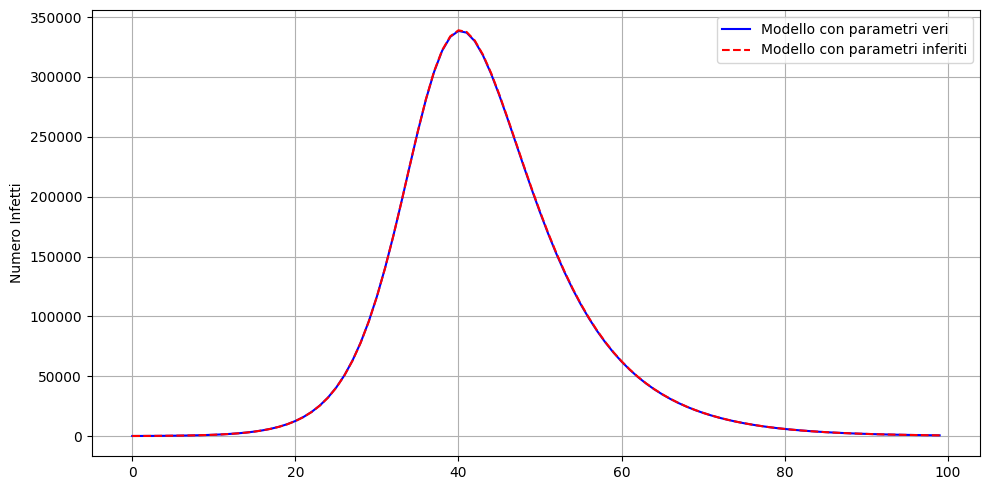

In [ ]:
burn_in = 1000
mean_estimates = np.mean(samples[:, -burn_in:, :], axis=(0, 1))
std_estimates = np.std(samples[:, -burn_in:, :], axis=(0, 1))

beta1_sampled, beta2_sampled, gamma_sampled, I0_sampled, scale_sampled, t_switch_sampled, dt_switched_sampled = mean_estimates

print("🔍 Parametri Verità:")
print(f"  Beta1: {true_params[0]:.4f}, Beta2: {true_params[1]:.4f}, gamma: {true_params[2]}, I0: {true_params[3]}, scale: {true_params[4]}, t_switch: {true_params[5]}, dt_switch: {true_params[6]}")

print("\n🔍 Parametri Inferiti:")
for name, mean, std in zip(param_names, mean_estimates, std_estimates):
    print(f"  {name}: {mean:.4f} ± {std:.4f}")
    
# ---- GENERIAMO LE DUE SIMULAZIONI ----
I_true_model = sir_discrete_single_switch(*true_params, t_max, N)
I_sampled_model = sir_discrete_single_switch(*mean_estimates, t_max, N)

# ---- PLOT CONFRONTO ----
figure = plt.figure(figsize = (10, 5))
# Plot Infected Cases
plt.plot(I_true_model, label="Modello con parametri veri", color="blue")
plt.plot(I_sampled_model, label="Modello con parametri inferiti", color="red", linestyle="dashed")
plt.ylabel("Numero Infetti")
plt.legend()
plt.grid()

fig.suptitle("📊 Confronto tra modello con parametri veri e inferiti")
plt.tight_layout()
plt.show()

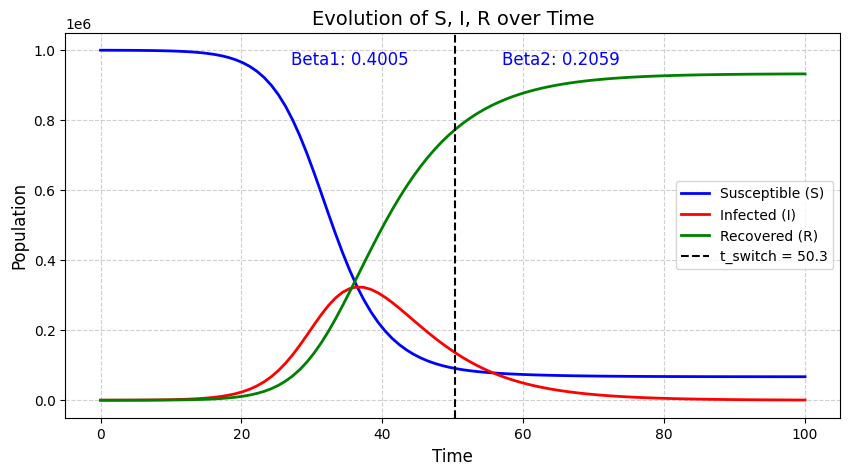

In [29]:
# Basic sir model, just for the plot 
def sir_model(y, t, beta_before, beta_after, gamma, t_switch, dt_switch):
    S, I, R = y
    # Change beta after day 50 - switching point
    transition = 1 / (1 + np.exp(-(t - t_switch) / dt_switch))
    beta = beta_before * (1 - transition) + beta_after * transition  # Interpolazione pesata
        
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]


# ---- SOLVE SIR MODEL USING ESTIMATED PARAMETERS ----
S0_est = N - I0_sampled
y0_est = [S0_est, I0_sampled, 0]  # Initial conditions

sol_est = odeint(sir_model, y0_est, t, args=(beta1_sampled, beta2_sampled, gamma_sampled, t_switch_sampled, dt_switched_sampled))
S_est, I_est, R_est = sol_est[:, 0], sol_est[:, 1], sol_est[:, 2]

# ---- PLOT THE EVOLUTION OF S, I, R ----

plt.figure(figsize=(10, 5))

# Traccia le curve per S, I, R
plt.plot(t, S_est, label="Susceptible (S)", color="blue", linewidth=2)
plt.plot(t, I_est, label="Infected (I)", color="red", linewidth=2)
plt.plot(t, R_est, label="Recovered (R)", color="green", linewidth=2)

# Linea verticale per t_switch
plt.axvline(x=t_switch_sampled, color="black", linestyle="dashed", linewidth=1.5, label=f"t_switch = {t_switch_sampled:.1f}")

# Aggiungi i valori di beta1 prima del t_switch
plt.text(t_switch_sampled - 15, max(S_est), f'Beta1: {beta1_sampled:.4f}', 
         fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')

# Aggiungi i valori di beta2 dopo il t_switch
plt.text(t_switch_sampled + 15, max(S_est), f'Beta2: {beta2_sampled:.4f}', 
         fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')

# Miglioramenti estetici
plt.xlabel("Time", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.title("Evolution of S, I, R over Time", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Mostra il grafico
plt.show()

In [ ]:
from SIR_functions import smooth_step_function, pt_lognormal, make_delay_matrix, apply_delay, delay_cases_lognormal, _SIR_model

true_params = {"beta1": 0.4, "beta2": 0.2, "gamma": 1/8, "I0": 100, "scale": 10, "delay": 8, "scale_delay": 0.5}
N = 1e6
t_max = 100
S = N - true_params["I0"]
t = np.linspace(0, 100, 100)
lambda_list = [0.4, 0.2]
num_days_sim = 100
tr_begin_list = [50] #[datetime(2020, 3, 9) + timedelta(days=50)]
tr_len_list = [3]

# --------------------------------------------------------------------------------------------
    # build the time-dependent spreading rate
lambda_t_list = [lambda_list[0] * pt.ones(num_days_sim)]
lambda_before = lambda_list[0]
for tr_begin, tr_len, lambda_after in zip(
    tr_begin_list, tr_len_list, lambda_list[1:]
):
    lambda_t = smooth_step_function(
        start_val=0,
        end_val=1,
        t_begin=tr_begin,
        t_end=tr_begin + tr_len,
        t_total=num_days_sim,
    ) * (lambda_after - lambda_before)
    lambda_before = lambda_after
    lambda_t_list.append(lambda_t)

lambda_t = sum(lambda_t_list)
lambda_t = lambda_t.astype("float64")
# ----------------------------------------------------------------------------------------------

S = np.float64(S)
N = np.float64(N)  # Se è un intero, lo converto esplicitamente a float
I0 = np.float64(true_params["I0"])
mu = np.float64(true_params["gamma"])
_, _, I_new_true = _SIR_model(lambda_t, mu, S, I0, N)

f = pytensor.function([], [I_new_true])
I_new_true = f()[0]

# Rumore osservativo t-Student
I_obs = I_new_true + stats.t.rvs(df=4, loc=0, scale=true_params["scale"], size=len(I_new_true))

date_begin_simulation = datetime(2020, 3, 9)
change_points_list = [50] # changing point at day 50 

change_points_list = [
    {
        "pr_mean_date_begin_transient": datetime(2020, 3, 9) + timedelta(days=50),  # Giorno 50 dalla data iniziale
        "pr_median_lambda": 0.4,  # λ₀ valore di default dalla tabella
        "pr_sigma_lambda": 0.5,  # σ per log-normal di λ₀
        "pr_sigma_date_begin_transient": 3,  # Default
        "pr_median_transient_len": 3,  # Default
        "pr_sigma_transient_len": 0.3,  # Default
    }
]

# ---- MODELLO BAYESIANO PyMC ----
with pm.Model() as model:
    beta1 = pm.Lognormal("beta1", mu=np.log(0.4), sigma=0.5)
    beta2 = pm.Lognormal("beta2", mu = np.log(0.2), sigma = 0.5)

    lambda_list = [beta1, beta2]

    # list of start dates of the transient periods of the change points
    tr_begin_list = []
    dt_before = date_begin_simulation
    for i, cp in enumerate(change_points_list):
        dt_begin_transient = cp["pr_mean_date_begin_transient"]
        if dt_before is not None and dt_before > dt_begin_transient:
            raise RuntimeError("Dates of change points are not temporally ordered")
        prior_mean = (
            dt_begin_transient - date_begin_simulation).days - 1  # convert the provided date format (argument) into days (a number)
        tr_begin = pm.Normal(
            name=f"transient_begin_{i}",
            mu=prior_mean,
            sigma=cp["pr_sigma_date_begin_transient"],
        )
        tr_begin_list.append(tr_begin)
        dt_before = dt_begin_transient
    # same for transient times
    tr_len_list = []
    for i, cp in enumerate(change_points_list):
        tr_len = pm.Lognormal(
            name=f"transient_len_{i}",
            mu=np.log(cp["pr_median_transient_len"]),
            sigma=cp["pr_sigma_transient_len"],
        )
        tr_len_list.append(tr_len)
    # build the time-dependent spreading rate
    lambda_t_list = [lambda_list[0] * pt.ones(num_days_sim)]
    lambda_before = lambda_list[0]

    for tr_begin, tr_len, lambda_after in zip(
        tr_begin_list, tr_len_list, lambda_list[1:]
    ):
        lambda_t = smooth_step_function(
            start_val=0,
            end_val=1,
            t_begin=tr_begin,
            t_end=tr_begin + tr_len,
            t_total=num_days_sim,
        ) * (lambda_after - lambda_before)
        lambda_before = lambda_after
        lambda_t_list.append(lambda_t)
    lambda_t = sum(lambda_t_list)
    
    gamma = pm.Lognormal("gamma", mu=np.log(1/8), sigma=0.2)
    I0 = pm.HalfCauchy("I0", beta=100)
    #delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.5)
    #scale_delay = pm.HalfNormal("scale_delay", sigma=1)
    scale = pm.HalfCauchy("scale", beta=10)

    S_begin = N - I0
    S, I, new_I = _SIR_model(
        lambda_t=lambda_t, mu=gamma, S_begin=S_begin, I_begin=I0, N=N
    )

    num_days_data = new_I.shape[-1]
    pm.StudentT("obs",
                 nu=4,
                 mu=new_I[:num_days_data],
                 sigma= scale, 
                 observed=I_obs)

    trace = pm.sample(2000, tune=500, cores=4, chains=4, target_accept=0.85)



az.plot_trace(trace)
plt.tight_layout()
plt.show()

c:\ProgramData\anaconda3\lib\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta2, transient_begin_0, transient_len_0, gamma, I0, scale]


Output()

In [ ]:
print(pm.summary(trace))

              mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
I0          29.827  13.442   9.016   53.577      0.817    0.578     267.0   
beta1        0.139   0.018   0.105    0.172      0.001    0.001     332.0   
beta2        0.131   0.044   0.055    0.213      0.004    0.003     114.0   
beta2_frac   0.937   0.280   0.511    1.566      0.028    0.020     100.0   
gamma        0.086   0.019   0.053    0.121      0.002    0.001     113.0   
scale       39.307   2.247  35.702   43.155      0.241    0.171      81.0   

            ess_tail  r_hat  
I0             501.0   1.00  
beta1          480.0   1.01  
beta2          330.0   1.02  
beta2_frac     278.0   1.01  
gamma          288.0   1.01  
scale           40.0   1.03  


         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
I0     37.613  44.173   0.145  117.219      4.450    3.156      94.0   
beta1   0.139   0.029   0.088    0.196      0.003    0.002      97.0   
beta2   0.259   0.068   0.134    0.375      0.006    0.004     149.0   
gamma   0.122   0.025   0.082    0.174      0.002    0.001     234.0   
scale  87.703   9.482  70.827  107.089      0.344    0.248     779.0   

       ess_tail  r_hat  
I0        164.0   1.02  
beta1     109.0   1.01  
beta2     238.0   1.01  
gamma     453.0   1.01  
scale     397.0   1.00

# SIR model with 1 switch and delay introduction

In this extended version of the SIR model with 1 switch, we are going to take into account also for a reporting delay.

| Parameter          | Variable   | Prior distribution              |
|-------------------|-----------|--------------------------------|
| Change point      | \( $t_1$ \)  | Normal(2020/03/09, 3)         |
| Change duration   | \( $\Delta t$ \) | LogNormal(log(3), 0.3)   |
| Spreading rates   | \( $\beta_0$ \) | LogNormal(log(0.4), 0.5)  |
|                   | \( $\beta_1$ \) | LogNormal(log(0.2), 0.5)  |
| Recovery rate     | \( $\gamma$ \)  | LogNormal(log(1/8), 0.2)     |
| Reporting delay   | \( D \)  | LogNormal(log(8), 0.2)       |
| Initially infected | \( $I_0$ \)  | HalfCauchy(100)               |
| Scale factor      | \( $\sigma$ \)  | HalfCauchy(10)                |

Running chain 1/20...
Running chain 2/20...
Running chain 3/20...
Running chain 4/20...
Running chain 5/20...
Running chain 6/20...
Running chain 7/20...
Running chain 8/20...
Running chain 9/20...
Running chain 10/20...
Running chain 11/20...
Running chain 12/20...
Running chain 13/20...
Running chain 14/20...
Running chain 15/20...
Running chain 16/20...
Running chain 17/20...
Running chain 18/20...
Running chain 19/20...
Running chain 20/20...


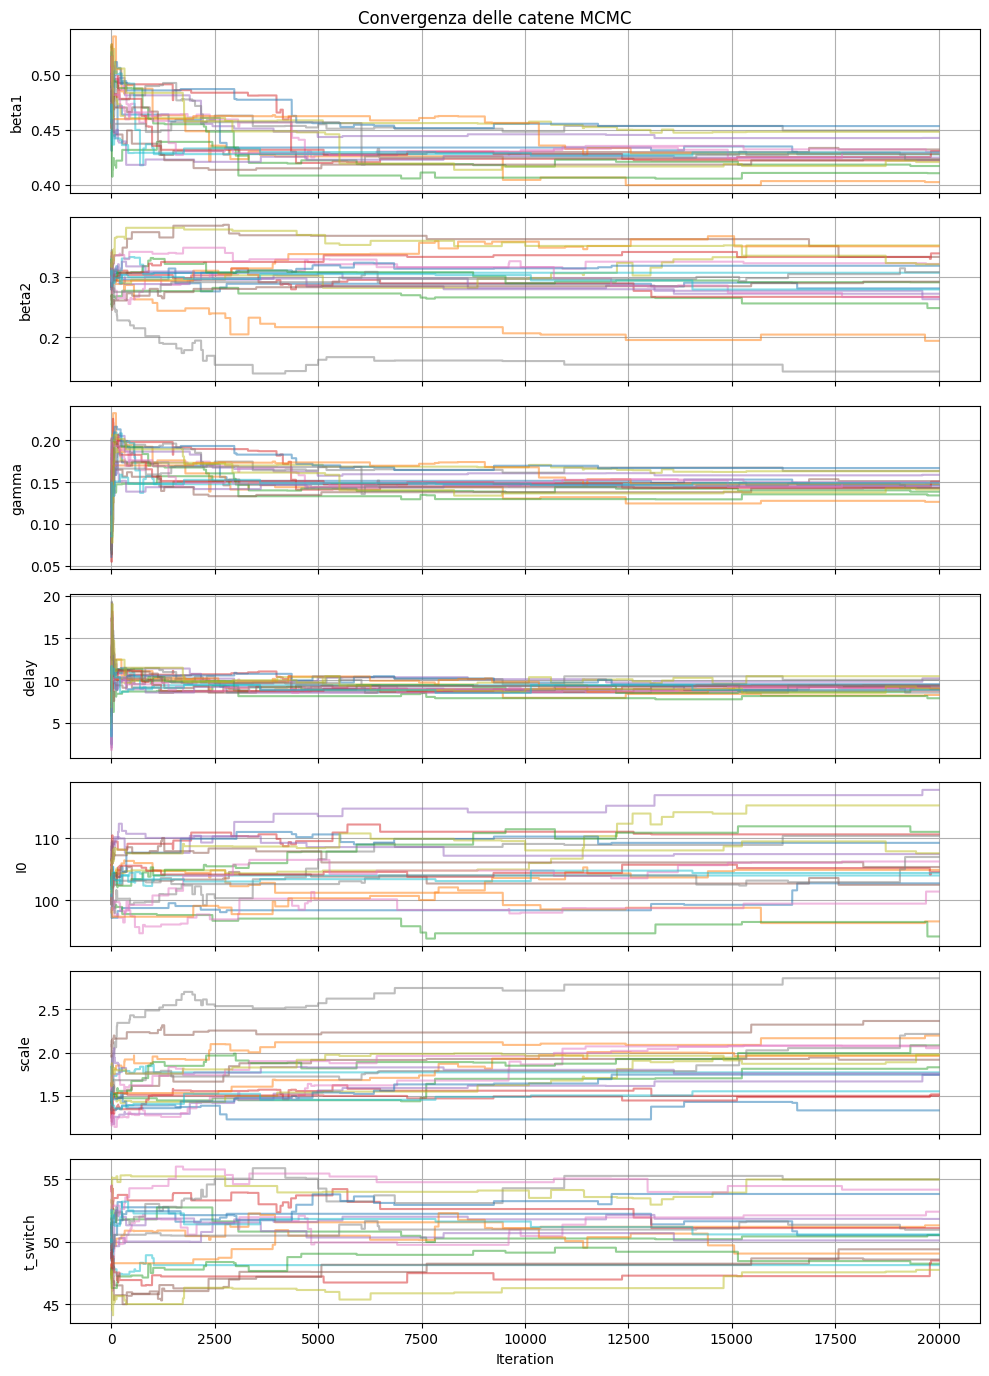

In [10]:
from SIR_functions import sir_discrete_delay_w_switch 

# ---- PARAMETERS ----
N = 1e6  # Population size
t_max = 100  # Total days of simulation
# Priors
N = 1e6
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_beta_2, mu_beta_2 = 0.5, np.log(0.2)
sigma_gamma, mu_gamma = 0.2, np.log(1/8)
sigma_delay, mu_delay = 0.2, np.log(8)
sigma_I0 = 100
sigma_scale = 10
sigma_time, mu_time = 0.3, np.log(3)
sigma_dt, mu_dt = 0.3, np.log(3)

# ---- PRIOR FUNCTION ----
def log_prior(beta_before, beta_after, gamma, delay, I0, scale, t_switch, dt_switch):
    logp = (
        stats.lognorm.logpdf(beta_before, s=0.5, scale=np.exp(np.log(0.4))) +
        stats.lognorm.logpdf(beta_after, s=sigma_beta_2, scale=np.exp(mu_beta_2)) +
        stats.lognorm.logpdf(gamma, s=0.2, scale=np.exp(np.log(1/8))) +
        stats.lognorm.logpdf(delay, s=0.2, scale=np.exp(np.log(8))) +
        stats.halfcauchy.logpdf(I0, scale=100) +
        stats.halfcauchy.logpdf(scale, scale=10) +
        stats.norm.logpdf(t_switch, loc=mu_time, scale=sigma_time) +
        stats.lognorm.logpdf(dt_switch, s = sigma_dt, scale = np.exp(mu_dt))
    )
    return logp

# ---- LOG-LIKELIHOOD ----
def log_likelihood(params, data):
    beta_before, beta_after, gamma, delay, I0, scale, t_switch, dt_switch = params
    I_pred, C_pred = sir_discrete_delay_w_switch(beta_before, beta_after, gamma, delay, I0, scale, t_switch, dt_switch, t_max, N)  # Solve SIR model with delay
    
    # Likelihood: Assume reported cases C_t follows Normal(C_pred, scale)
    return np.sum(stats.norm.logpdf(data, loc=C_pred, scale=scale))

# ---- LOG-POSTERIOR ----
def log_posterior(params, data):
    beta_before, beta_after, gamma, delay, I0, scale, t_switch, dt_switch = params
    prior = log_prior(beta_before, beta_after, gamma, delay, I0, scale, t_switch, dt_switch)
    if np.isinf(prior) or np.isnan(prior):
        return -np.inf  # Reject invalid samples
    return prior + log_likelihood(params, data)

n_chains = 20
# ---- SIMULATE DATA ----
true_params = [0.4, 0.2, 1/8, 8, 100, 2, 50, 3]  # True values for beta, gamma, delay, I0, scale
I_true, C_true = sir_discrete_delay_w_switch(*true_params, t_max, N)  # Generate true epidemic curve
C_true += np.random.normal(0, true_params[4], size=t_max)  # Add noise

# ---- RUN MCMC ----
initial_guess = [0.5, 0.3, 0.1, 5, 103, 1.5, 50, 3]  # Initial parameter guess

initial_params_list = [
    initial_guess + np.random.normal(0, [0.02, 0.02, 0.02, 2, 2, 0.2, 2, 0.2], 8)
    for _ in range(n_chains)
]

step_sizes_list = [
    np.array([0.01, 0.01, 0.02, 2, 1, 0.05, 0.5, 0.05]) + np.random.uniform(-0.005, 0.005, 8)
    for _ in range(n_chains)
]

samples = metropolis_hastings_multi_chain(log_posterior, initial_params_list, step_sizes_list, C_true, n_iter=20000, n_chains=n_chains)

# ---- PLOT RESULTS IN SUBPLOTS ----
param_names = ["beta1", "beta2", "gamma", "delay", "I0", "scale", "t_switch"]
fig, axes = plt.subplots(len(param_names), 1, figsize=(10, 2 * len(param_names)), sharex=True)

for i, ax in enumerate(axes):
    for chain in samples:
        ax.plot(chain[:, i], alpha=0.5)
    ax.set_ylabel(param_names[i])
    ax.grid()

axes[-1].set_xlabel("Iteration")
plt.suptitle("Convergenza delle catene MCMC")
plt.tight_layout()
plt.show()


🔍 Parametri Verità:
  Beta1: 0.4000, Beta2: 0.2000, gamma: 0.125, delay: 8, I0: 100, scale: 2, t_switch: 50, dt_switch: 3

🔍 Parametri Inferiti:
  beta1: 0.4254 ± 0.0188
  beta2: 0.2898 ± 0.0516
  gamma: 0.1448 ± 0.0147
  delay: 8.9940 ± 0.7674
  I0: 105.6205 ± 7.0871
  scale: 1.8364 ± 0.3761
  t_switch: 50.0695 ± 2.0221


C:\Users\adadi\AppData\Local\Temp\ipykernel_29508\903742720.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


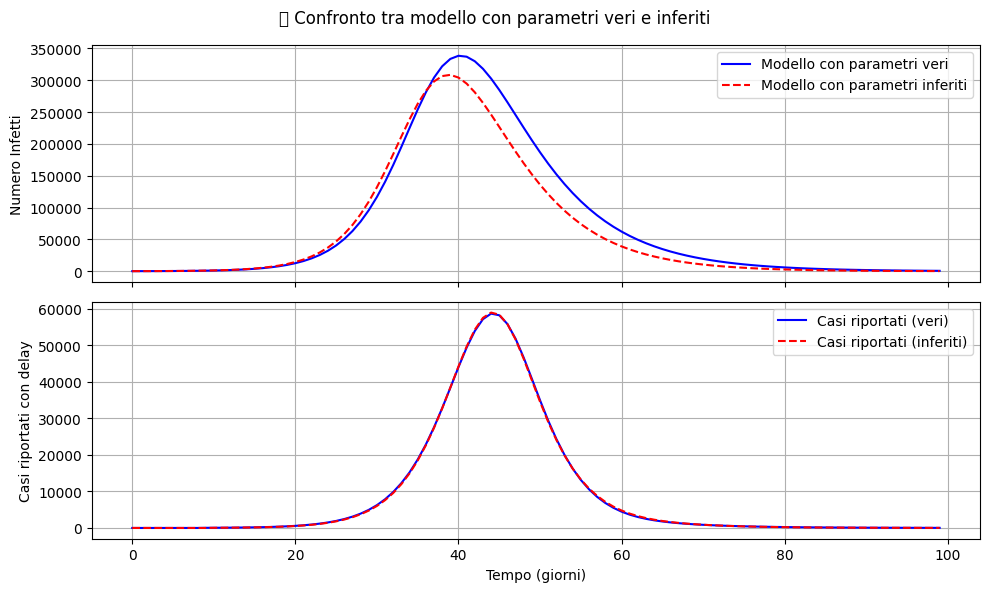

In [ ]:
burn_in = 1000
mean_estimates = np.mean(samples[:, -burn_in:, :], axis=(0, 1))
std_estimates = np.std(samples[:, -burn_in:, :], axis=(0, 1))

beta1_sampled, beta2_sampled, gamma_sampled, delay_sampled, I0_sampled, scale_sampled, t_switch_sampled, dt_switch_sampled = mean_estimates

print("🔍 Parametri Verità:")
print(f"  Beta1: {true_params[0]:.4f}, Beta2: {true_params[1]:.4f}, gamma: {true_params[2]}, delay: {true_params[3]}, I0: {true_params[4]}, scale: {true_params[5]}, t_switch: {true_params[6]}, dt_switch: {true_params[7]}")

print("\n🔍 Parametri Inferiti:")
for name, mean, std in zip(param_names, mean_estimates, std_estimates):
    print(f"  {name}: {mean:.4f} ± {std:.4f}")
    
# ---- GENERIAMO LE DUE SIMULAZIONI ----
I_true_model, C_true_model = sir_discrete_delay_w_switch(*true_params, t_max, N)
I_sampled_model, C_sampled_model = sir_discrete_delay_w_switch(beta1_sampled, beta2_sampled, gamma_sampled, delay_sampled, I0_sampled, scale_sampled, t_switch_sampled, dt_switch_sampled, t_max, N)

# ---- PLOT CONFRONTO ----
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot Infected Cases
ax[0].plot(I_true_model, label="Modello con parametri veri", color="blue")
ax[0].plot(I_sampled_model, label="Modello con parametri inferiti", color="red", linestyle="dashed")
ax[0].set_ylabel("Numero Infetti")
ax[0].legend()
ax[0].grid()

# Plot Reported Cases (con delay)
ax[1].plot(C_true_model, label="Casi riportati (veri)", color="blue")
ax[1].plot(C_sampled_model, label="Casi riportati (inferiti)", color="red", linestyle="dashed")
ax[1].set_ylabel("Casi riportati con delay")
ax[1].set_xlabel("Tempo (giorni)")
ax[1].legend()
ax[1].grid()

fig.suptitle("📊 Confronto tra modello con parametri veri e inferiti")
plt.tight_layout()
plt.show()

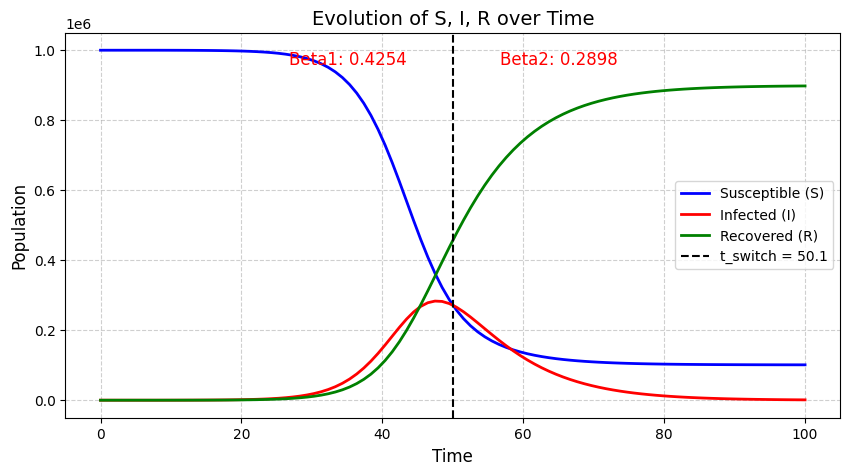

In [48]:
def sir_model(y, t, beta_before, beta_after, gamma, delay, t_switch, dt_switch, N, I_sampled_model):
    S, I, R = y  # Non include più I_past, lo otteniamo direttamente da I_sampled_model
    
    # Calcolare il valore di beta in base al tempo
    transition = 1 / (1 + np.exp(-(t - t_switch) / dt_switch))
    beta = beta_before * (1 - transition) + beta_after * transition  # Interpolazione pesata per beta
    
    # Introduciamo il ritardo: accediamo all'array delle infezioni passate (delay)
    # In caso di ritardo, I_past corrisponde a I[t - delay] se t - delay è valido
    if int(t - delay) >= 0:  # Assicurati che t - delay sia un indice valido
        I_past = I_sampled_model[int(t - delay)]  # Infezioni avvenute 'delay' giorni fa
    else:
        I_past = 0  # Se t - delay è negativo, considera che non ci sono infezioni passate
    
    # Calcolare le derivate
    dSdt = -beta * S * I_past / N  # Nuove infezioni dipendono dalle infezioni ritardate
    dIdt = beta * S * I_past / N - gamma * I  # Infezioni e recupero
    dRdt = gamma * I  # Recuperi
    
    return [dSdt, dIdt, dRdt]  # Non è più necessario restituire I_past_array

# ---- RISOLVI IL MODELLO SIR CON I PARAMETRI STIMATI ----
S0_est = N - I0_sampled
y0_est = [S0_est, I0_sampled, 0]  # Condizioni iniziali

# Risolvere il modello SIR usando i parametri stimati
sol_est = odeint(sir_model, y0_est, t, args=(beta1_sampled, beta2_sampled, gamma_sampled, delay_sampled, t_switch_sampled, dt_switched_sampled, N, I_sampled_model))
S_est, I_est, R_est = sol_est[:, 0], sol_est[:, 1], sol_est[:, 2]

# ---- PLOT THE EVOLUTION OF S, I, R ----

plt.figure(figsize=(10, 5))

# Traccia le curve per S, I, R
plt.plot(t, S_est, label="Susceptible (S)", color="blue", linewidth=2)
plt.plot(t, I_est, label="Infected (I)", color="red", linewidth=2)
plt.plot(t, R_est, label="Recovered (R)", color="green", linewidth=2)

# Linea verticale per t_switch
plt.axvline(x=t_switch_sampled, color="black", linestyle="dashed", linewidth=1.5, label=f"t_switch = {t_switch_sampled:.1f}")

# Aggiungi i valori di beta1 prima del t_switch
plt.text(t_switch_sampled - 15, max(S_est), f'Beta1: {beta1_sampled:.4f}', 
         fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# Aggiungi i valori di beta2 dopo il t_switch
plt.text(t_switch_sampled + 15, max(S_est), f'Beta2: {beta2_sampled:.4f}', 
         fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# Miglioramenti estetici
plt.xlabel("Time", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.title("Evolution of S, I, R over Time", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Mostra il grafico
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta2, gamma, delay, I0, scale]


C:\Users\adadi\AppData\Roaming\Python\Python310\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 2_000 tune and 5_000 draw iterations (4_000 + 10_000 draws total) took 29177 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


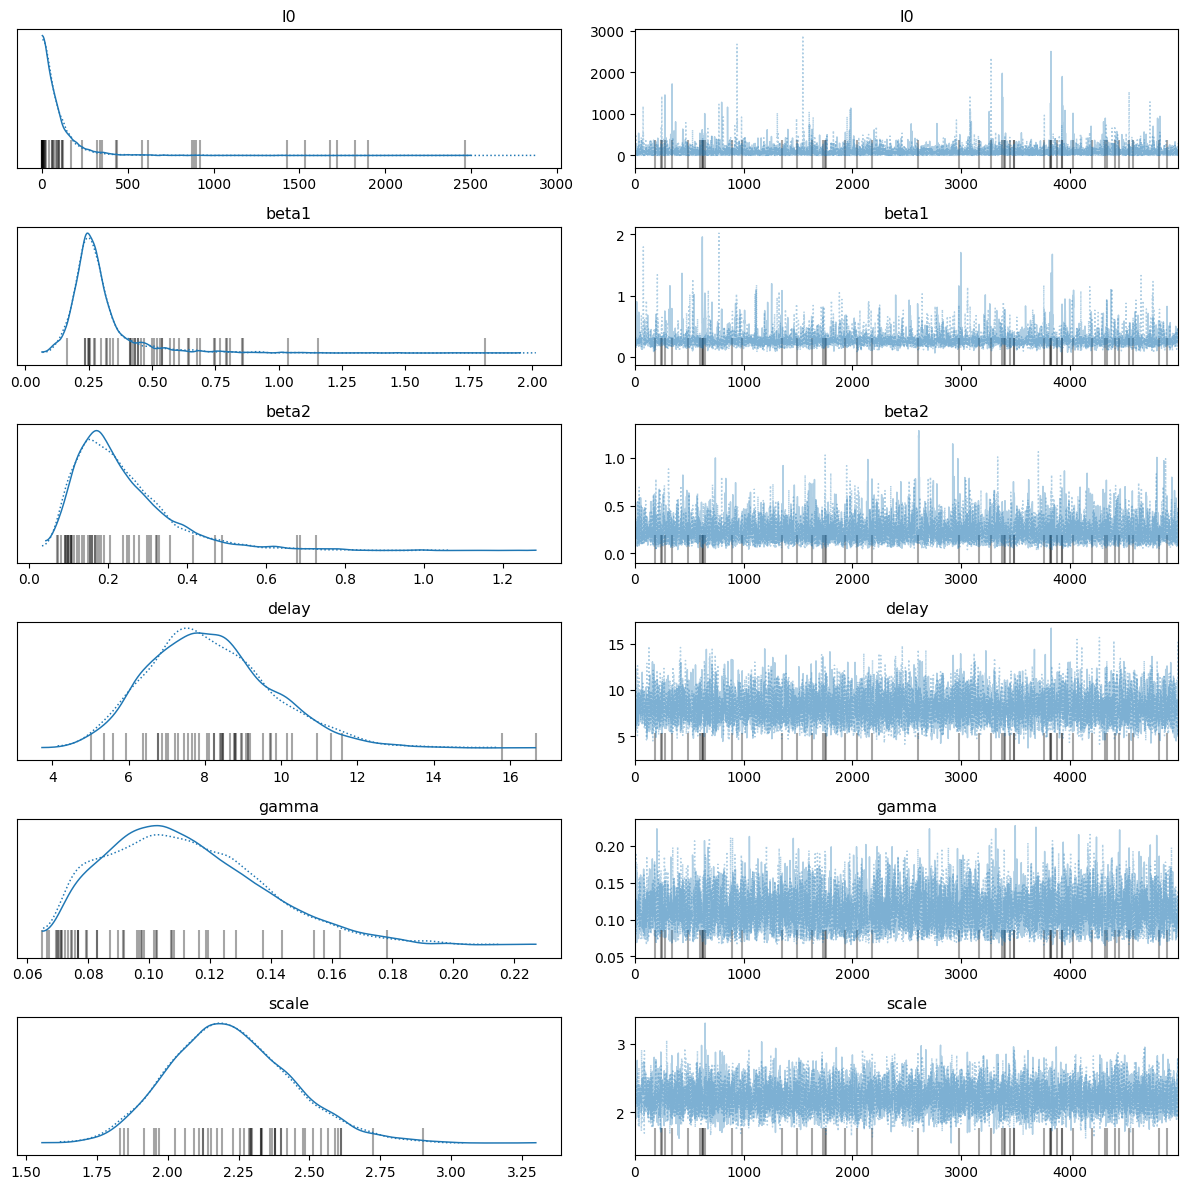

In [ ]:
# SIR model with 1 switch and delay 
from SIR_functions import smooth_step_function, pt_lognormal, make_delay_matrix, apply_delay, delay_cases_lognormal, _SIR_model

# ---- SIMULAZIONE DATI ----
true_params = {"beta1": 0.4, "beta1": 0.2, "gamma": 1/8, "I0": 100, "scale": 10, "delay": 8, "scale_delay": 0.5}
N = 1e6
t_max = 100
S = N - true_params["I0"]
t = np.linspace(0, 100, 100)
lambda_list = [0.4, 0.2]
num_days_sim = 100
tr_begin_list = [50] #[datetime(2020, 3, 9) + timedelta(days=50)]
tr_len_list = [3]
# SIR deterministico

# --------------------------------------------------------------------------------------------
lambda_t_list = [lambda_list[0] * pt.ones(num_days_sim)]
lambda_before = lambda_list[0]
for tr_begin, tr_len, lambda_after in zip(
    tr_begin_list, tr_len_list, lambda_list[1:]
):
    lambda_t = smooth_step_function(
        start_val=0,
        end_val=1,
        t_begin=tr_begin,
        t_end=tr_begin + tr_len,
        t_total=num_days_sim,
    ) * (lambda_after - lambda_before)
    lambda_before = lambda_after
    lambda_t_list.append(lambda_t)

lambda_t = sum(lambda_t_list)
lambda_t = lambda_t.astype("float64")
# ----------------------------------------------------------------------------------------------

S = np.float64(S)
N = np.float64(N)  # Se è un intero, lo converto esplicitamente a float
I0 = np.float64(true_params["I0"])
mu = np.float64(true_params["gamma"])
_, _, I_new_true = _SIR_model(lambda_t, mu, S, I0, N)

f = pytensor.function([], [I_new_true])
I_new_true = f()[0]

# ----------------------------------------------
# Rumore osservativo t-Student
lognorm_kernel_sim = stats.lognorm.pdf(make_delay_matrix(t_max, t_max), s=true_params["scale_delay"], scale=true_params["delay"])
lognorm_kernel_sim /= lognorm_kernel_sim.sum(axis=1, keepdims=True)
C_obs = np.dot(I_new_true, lognorm_kernel_sim)

# Rumore osservativo t-Student
C_obs += stats.t.rvs(df=4, loc=0, scale=true_params["scale"], size=len(C_obs))

date_begin_simulation = datetime(2020, 3, 9)
change_points_list = [50] # changing point at day 50 

change_points_list = [
    {
        "pr_mean_date_begin_transient": datetime(2020, 3, 9) + timedelta(days=50),  # Giorno 50 dalla data iniziale
        "pr_median_lambda": 0.2,  # λ₀ valore di default dalla tabella
        "pr_sigma_lambda": 0.5,  # σ per log-normal di λ₀
        "pr_sigma_date_begin_transient": 3,  # Default
        "pr_median_transient_len": 3,  # Default
        "pr_sigma_transient_len": 0.3,  # Default
    }
]

# ---- MODELLO BAYESIANO PyMC ----
with pm.Model() as model:
    beta1 = pm.Lognormal("beta1", mu=np.log(0.4), sigma=0.5)
    beta2 = pm.Lognormal("beta2", mu = np.log(0.2), sigma = 0.5)

    lambda_list = [beta1, beta2]

    # list of start dates of the transient periods of the change points
    tr_begin_list = []
    dt_before = date_begin_simulation
    for i, cp in enumerate(change_points_list):
        dt_begin_transient = cp["pr_mean_date_begin_transient"]
        if dt_before is not None and dt_before > dt_begin_transient:
            raise RuntimeError("Dates of change points are not temporally ordered")
        prior_mean = (
            dt_begin_transient - date_begin_simulation).days - 1  # convert the provided date format (argument) into days (a number)
        tr_begin = pm.Normal(
            name=f"transient_begin_{i}",
            mu=prior_mean,
            sigma=cp["pr_sigma_date_begin_transient"],
        )
        tr_begin_list.append(tr_begin)
        dt_before = dt_begin_transient
    # same for transient times
    tr_len_list = []
    for i, cp in enumerate(change_points_list):
        tr_len = pm.Lognormal(
            name=f"transient_len_{i}",
            mu=np.log(cp["pr_median_transient_len"]),
            sigma=cp["pr_sigma_transient_len"],
        )
        tr_len_list.append(tr_len)
    # build the time-dependent spreading rate
    lambda_t_list = [lambda_list[0] * pt.ones(num_days_sim)]
    lambda_before = lambda_list[0]

    for tr_begin, tr_len, lambda_after in zip(
        tr_begin_list, tr_len_list, lambda_list[1:]
    ):
        lambda_t = smooth_step_function(
            start_val=0,
            end_val=1,
            t_begin=tr_begin,
            t_end=tr_begin + tr_len,
            t_total=num_days_sim,
        ) * (lambda_after - lambda_before)
        lambda_before = lambda_after
        lambda_t_list.append(lambda_t)
    lambda_t = sum(lambda_t_list)
    
    gamma = pm.Lognormal("gamma", mu=np.log(1/8), sigma=0.2)
    I0 = pm.HalfCauchy("I0", beta=100)
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.5)
    scale_delay = pm.HalfNormal("scale_delay", sigma=1)
    scale = pm.HalfCauchy("scale", beta=10)

    S_begin = N - I0
    S, I, new_I = _SIR_model(
        lambda_t=lambda_t, mu=gamma, S_begin=S_begin, I_begin=I0, N=N
    )
    C_pred = pm.Deterministic("C_pred", delay_cases_lognormal(new_I, t_max, t_max, delay, scale_delay))

    num_days_data = C_pred.shape[-1]
    pm.StudentT("obs",
                 nu=4,
                 mu=C_pred[:num_days_data],
                 sigma= scale, 
                 observed=C_obs)

    trace = pm.sample(2000, tune=500, cores=4, chains=4, target_accept=0.85)



az.plot_trace(trace)
plt.tight_layout()
plt.show()

         mean       sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
beta1   0.289    0.134   0.116    0.425      0.003    0.002    3240.0   
beta2   0.234    0.124   0.066    0.401      0.002    0.001    7129.0   
gamma   0.112    0.026   0.071    0.149      0.000    0.000    4710.0   
delay   8.152    1.631   5.528   10.771      0.019    0.014    7219.0   
I0     94.649  141.139   0.014  203.129      2.270    1.641    5946.0   
scale   2.223    0.212   1.884    2.580      0.002    0.002    8075.0   

       ess_tail  r_hat  
beta1    3347.0    1.0  
beta2    6037.0    1.0  
gamma    4904.0    1.0  
delay    6349.0    1.0  
I0       4245.0    1.0  
scale    5797.0    1.0  

🔍 Parametri Verità:
  Beta1: 0.4000, Beta2: 0.2000, Gamma: 0.1000, Delay: 8.00, I0: 10, Scale: 2

🔍 Parametri Inferiti:
  Beta1: 0.2894, Beta2: 0.2345, Gamma: 0.1119, Delay: 8.15, I0: 94.6491693726306, Scale: 2.2234081909836303


C:\Users\adadi\AppData\Local\Temp\ipykernel_10832\1889801157.py:43: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


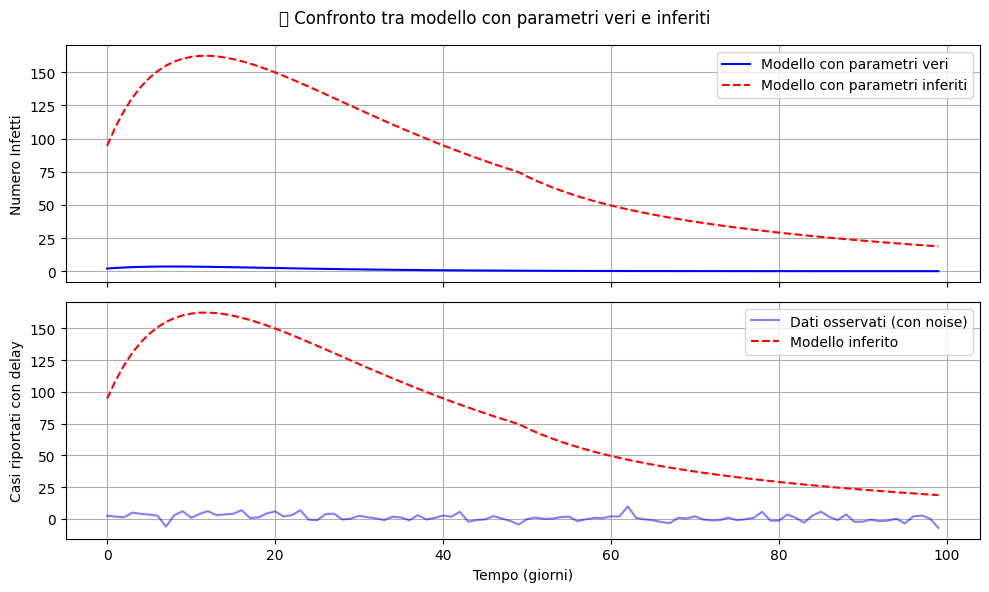

In [ ]:
summary = az.summary(trace)
print(summary.tail(10))


# SIR model with 3 switches    

Three different switching points are now predicted in the model, in order to describe the spreading of a pandemic.

| Parameter          | Variable   | Prior distribution              |
|-------------------|-----------|--------------------------------|
| Change points     | \( $t_1$ \)  | Normal(2020/03/09, 3)         |
|                   | \( $t_2$ \)  | Normal(2020/03/16, 1)         |
|                   | \( $t_3$ \)  | Normal(2020/03/23, 1)         |
| Change duration   | \( $\Delta t_i$ \) | LogNormal(log(3), 0.3)   |
| Spreading rates   | \( $\beta_0$ \) | LogNormal(log(0.4), 0.5)  |
|                   | \( $\beta_1$ \) | LogNormal(log(0.2), 0.5)  |
|                   | \( $\beta_2$ \) | LogNormal(log(1/8), 0.5)  |
|                   | \( $\beta_3$ \) | LogNormal(log(1/16), 0.5) |
| Recovery rate     | \( $\gamma $\)  | LogNormal(log(1/8), 0.2)     |
| Reporting delay   | \( D \)  | LogNormal(log(8), 0.2)       |
| Initially infected | \( $I_0$ \)  | HalfCauchy(100)               |
| Scale factor      | \( $\sigma$ \)  | HalfCauchy(10)                |


In [2]:
from SIR_functions import sir_discrete_multi_sw
# Parameters
N = 1e6 # population size 
t = np.linspace(0, 100, 100) # time grid 

beta_vals = [0.4, 0.2, 1/8, 1/16]
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_beta_2, mu_beta_2 = 0.5, np.log(0.2)
sigma_beta_3, mu_beta_3 = 0.5, np.log(1/8)
sigma_beta_4, mu_beta_4 = 0.5, np.log(1/16)
sigma_gamma, mu_gamma = 0.2, np.log(1/8)
sigma_I0 = 100
sigma_scale = 100 # 10 before 
sigma_time1, mu_time1 = 3, 50
sigma_time2, mu_time2 = 1, 57
sigma_time3, mu_time3 = 1, 64
sigma_dt, mu_dt = 0.3, np.log(3)

In [3]:
# Modello con le prior del paper 
def log_prior(beta1, beta2, beta3, beta4, gamma, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch):
    logp = (    
        stats.lognorm.logpdf(beta1, s=sigma_beta, scale=np.exp(mu_beta)) +
        stats.lognorm.logpdf(beta2, s=sigma_beta_2, scale=np.exp(mu_beta_2)) +
        stats.lognorm.logpdf(beta3, s=sigma_beta_3, scale=np.exp(mu_beta_3)) +
        stats.lognorm.logpdf(beta4, s=sigma_beta_4, scale=np.exp(mu_beta_4)) +
        stats.lognorm.logpdf(gamma, s=sigma_gamma, scale=np.exp(mu_gamma)) +
        stats.halfcauchy.logpdf(I0, scale=sigma_I0) +
        stats.halfcauchy.logpdf(scale, scale=sigma_scale) +
        stats.norm.logpdf(t_switch1, loc = mu_time1, scale = sigma_time1) +
        stats.norm.logpdf(t_switch2, loc = mu_time2, scale = sigma_time2) +
        stats.norm.logpdf(t_switch3, loc = mu_time3, scale = sigma_time3) + 
        stats.lognorm.logpdf(dt_switch, s = sigma_dt, scale = np.exp(mu_dt))
    )
    return logp

In [4]:
# ---- LOG-LIKELIHOOD ----
def log_likelihood(params, data):
    beta1, beta2, beta3, beta4, gamma, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch = params
    I_pred = sir_discrete_multi_sw(beta1, beta2, beta3, beta4, gamma, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch, t_max, N)  # Solve SIR model with delay
    
    # Likelihood: Assume reported cases C_t follows Normal(C_pred, scale)
    return np.sum(stats.norm.logpdf(data, loc=I_pred, scale=scale))


In [5]:
# ---- LOG-POSTERIOR ----
def log_posterior(params, data):
    beta1, beta2, beta3, beta4, gamma, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch = params
    prior = log_prior(beta1, beta2, beta3, beta4, gamma, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch)
    if np.isinf(prior) or np.isnan(prior):
        return -np.inf  # Reject invalid samples
    return prior + log_likelihood(params, data)

Running chain 1/20...


c:\Users\adadi\OneDrive\Desktop\IT_project\SIR_functions.py:241: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(logp_new - logp_old)


Running chain 2/20...
Running chain 3/20...
Running chain 4/20...
Running chain 5/20...
Running chain 6/20...
Running chain 7/20...
Running chain 8/20...
Running chain 9/20...
Running chain 10/20...
Running chain 11/20...
Running chain 12/20...
Running chain 13/20...
Running chain 14/20...
Running chain 15/20...
Running chain 16/20...
Running chain 17/20...
Running chain 18/20...
Running chain 19/20...
Running chain 20/20...


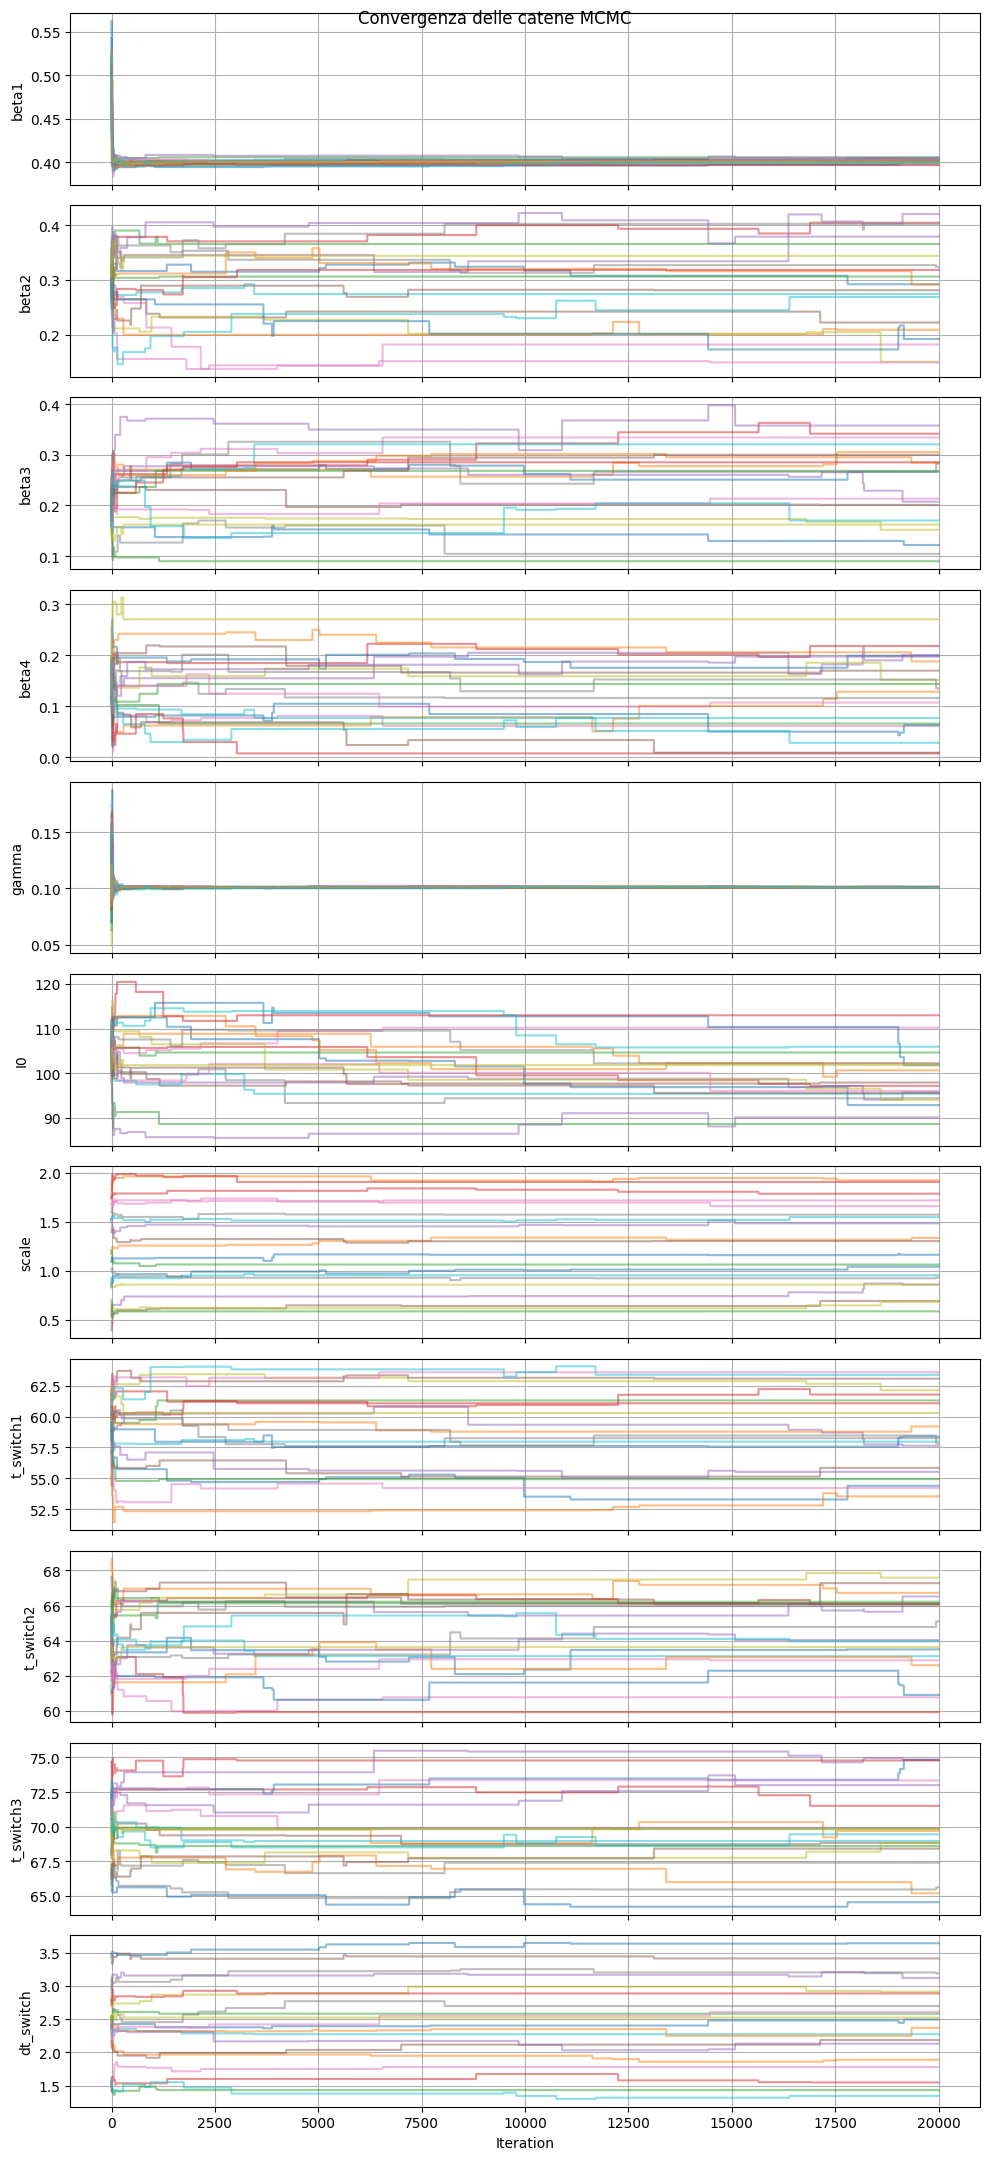

In [6]:
n_chains = 20
t_max = 100
true_params = [0.4, 0.2, 1/8, 1/16, 0.1, 100, 2, 50, 57, 64, 3]  # True values for beta_before, beta_after, gamma, I0, scale
I_true = sir_discrete_multi_sw(*true_params, t_max, N)  # Generate true epidemic curve
I_true += np.random.normal(0, true_params[6], size=t_max)  # Add noise

# ---- RUN MCMC ----
initial_guess = [0.5, 0.3, 0.2, 0.15, 0.09, 105, 1.5, 60, 65, 70, 2.5]  # beta1, beta2, beta3, beta4, gamma, I0, scale, t1, t2, t3, t4, dt

initial_params_list = [
    initial_guess + np.random.normal(0, [0.02, 0.02, 0.02, 0.02, 0.02, 2, 0.5, 2, 2, 2, 0.5], 11)
    for _ in range(n_chains)
]

step_sizes_list = [
    np.array([0.02, 0.02, 0.02, 0.02, 0.02, 2, 0.02, 0.5, 0.5, 0.5, 0.05]) + np.random.uniform(-0.005, 0.005, 11)
    for _ in range(n_chains)
]

samples = metropolis_hastings_multi_chain(log_posterior, initial_params_list, step_sizes_list, I_true, n_iter=20000, n_chains=n_chains)

# ---- PLOT RESULTS IN SUBPLOTS ----
param_names = ["beta1", "beta2", "beta3", "beta4", "gamma", "I0", "scale", "t_switch1", "t_switch2", "t_switch3", "dt_switch"]
fig, axes = plt.subplots(len(param_names), 1, figsize=(10, 2 * len(param_names)), sharex=True)

for i, ax in enumerate(axes):
    for chain in samples:
        ax.plot(chain[:, i], alpha=0.5)
    ax.set_ylabel(param_names[i])
    ax.grid()

axes[-1].set_xlabel("Iteration")
plt.suptitle("Convergenza delle catene MCMC")
plt.tight_layout()
plt.show()

🔍 Parametri Verità:
  Beta1: 0.4000, Beta2: 0.2000, Beta3: 0.1250, Beta4: 0.0625, gamma: 0.1, I0: 100, scale: 2, t_switch1: 50,  t_switch2: 57,  t_switch3: 64, dt_switch: 3

🔍 Parametri Inferiti:
  beta1: 0.4018 ± 0.0024
  beta2: 0.2894 ± 0.0817
  beta3: 0.2381 ± 0.0807
  beta4: 0.1281 ± 0.0727
  gamma: 0.1011 ± 0.0003
  I0: 99.0135 ± 6.1934
  scale: 1.2500 ± 0.4168
  t_switch1: 58.7385 ± 3.1720
  t_switch2: 64.4418 ± 2.1910
  t_switch3: 69.8736 ± 2.9741
  dt_switch: 2.4501 ± 0.6287


C:\Users\adadi\AppData\Local\Temp\ipykernel_27068\3551161833.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


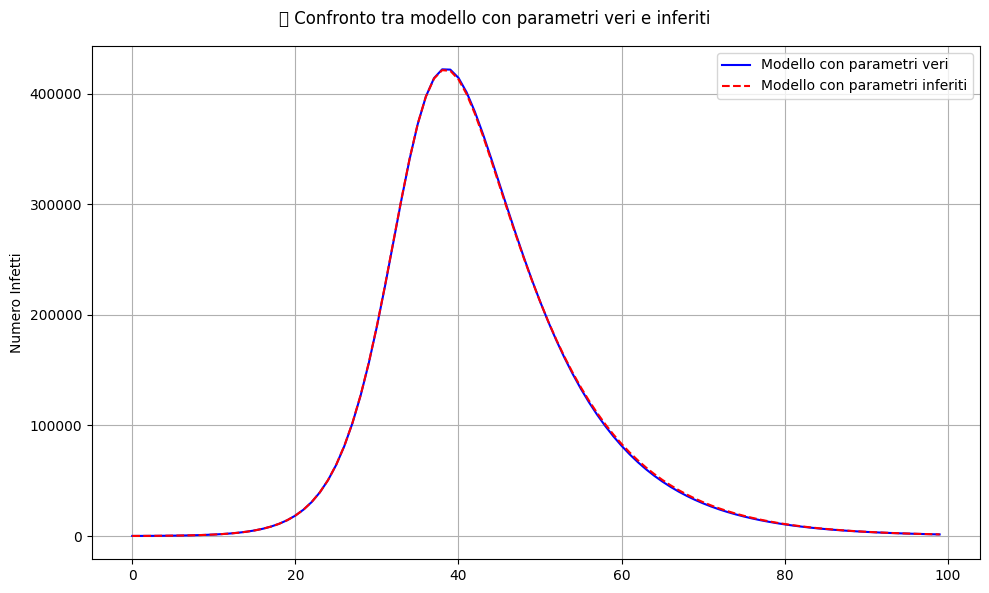

In [7]:
burn_in = 1000
mean_estimates = np.mean(samples[:, -burn_in:, :], axis=(0, 1))
std_estimates = np.std(samples[:, -burn_in:, :], axis=(0, 1))

beta1_sampled, beta2_sampled, beta3_sampled, beta4_sampled, gamma_sampled, I0_sampled, scale_sampled, t_switch1_sampled, t_switch2_sampled, t_switch3_sampled, dt_switch_sampled = mean_estimates

print("🔍 Parametri Verità:")
print(f"  Beta1: {true_params[0]:.4f}, Beta2: {true_params[1]:.4f}, Beta3: {true_params[2]:.4f}, Beta4: {true_params[3]:.4f}, gamma: {true_params[4]}, I0: {true_params[5]}, scale: {true_params[6]}, t_switch1: {true_params[7]},  t_switch2: {true_params[8]},  t_switch3: {true_params[9]}, dt_switch: {true_params[10]}")

print("\n🔍 Parametri Inferiti:")
for name, mean, std in zip(param_names, mean_estimates, std_estimates):
    print(f"  {name}: {mean:.4f} ± {std:.4f}")
    
# ---- GENERIAMO LE DUE SIMULAZIONI ----
I_true_model = sir_discrete_multi_sw(*true_params, t_max, N)
I_sampled_model = sir_discrete_multi_sw(*mean_estimates, t_max, N)

# ---- PLOT CONFRONTO ----
fig = plt.figure(figsize=(10, 6))

# Plot Infected Cases
plt.plot(I_true_model, label="Modello con parametri veri", color="blue")
plt.plot(I_sampled_model, label="Modello con parametri inferiti", color="red", linestyle="dashed")
plt.ylabel("Numero Infetti")
plt.legend()
plt.grid()

fig.suptitle("📊 Confronto tra modello con parametri veri e inferiti")
plt.tight_layout()
plt.show()

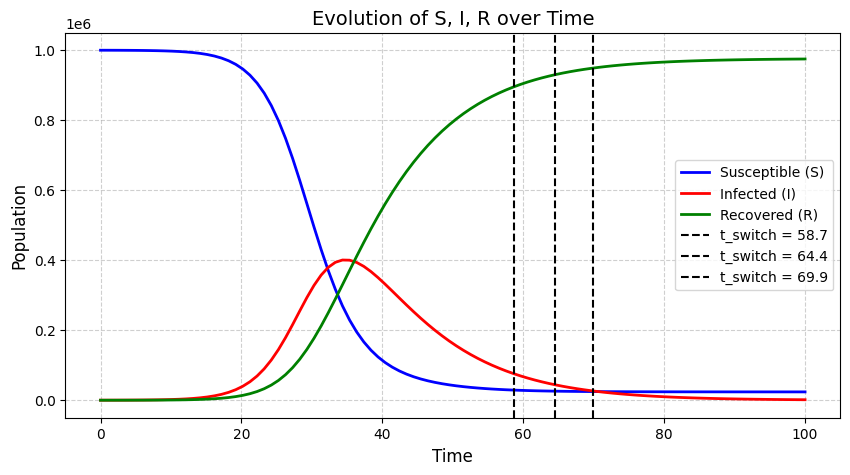

In [8]:
# Basic sir model, just for the plot 
def sir_model(y, t, beta1, beta2, beta3, beta4, gamma, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch):
    S, I, R = y
        # Smooth transitions between beta values   
    transition1 = 1 / (1 + np.exp(-(t - t_switch1) / dt_switch))
    transition2 = 1 / (1 + np.exp(-(t - t_switch2) / dt_switch))
    transition3 = 1 / (1 + np.exp(-(t - t_switch3) / dt_switch))

        # Weighted combination of beta values
    beta = (beta1 * (1 - transition1) + 
            beta2 * (transition1 * (1 - transition2)) + 
            beta3 * (transition2 * (1 - transition3)) + 
            beta4 * transition3)
    
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]


# ---- SOLVE SIR MODEL USING ESTIMATED PARAMETERS ----
S0_est = N - I0_sampled
y0_est = [S0_est, I0_sampled, 0]  # Initial conditions

sol_est = odeint(sir_model, y0_est, t, args=(beta1_sampled, beta2_sampled, beta3_sampled, beta4_sampled, 
                                             gamma_sampled, I0_sampled, scale_sampled, t_switch1_sampled, 
                                             t_switch2_sampled, t_switch3_sampled, dt_switch_sampled))

S_est, I_est, R_est = sol_est[:, 0], sol_est[:, 1], sol_est[:, 2]

# ---- PLOT THE EVOLUTION OF S, I, R ----

plt.figure(figsize=(10, 5))

# Traccia le curve per S, I, R
plt.plot(t, S_est, label="Susceptible (S)", color="blue", linewidth=2)
plt.plot(t, I_est, label="Infected (I)", color="red", linewidth=2)
plt.plot(t, R_est, label="Recovered (R)", color="green", linewidth=2)

# Linea verticale per t_switch
plt.axvline(x=t_switch1_sampled, color="black", linestyle="dashed", linewidth=1.5, label=f"t_switch = {t_switch1_sampled:.1f}")
plt.axvline(x=t_switch2_sampled, color="black", linestyle="dashed", linewidth=1.5, label=f"t_switch = {t_switch2_sampled:.1f}")
plt.axvline(x=t_switch3_sampled, color="black", linestyle="dashed", linewidth=1.5, label=f"t_switch = {t_switch3_sampled:.1f}")



# Miglioramenti estetici
plt.xlabel("Time", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.title("Evolution of S, I, R over Time", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Mostra il grafico
plt.show()

In [83]:
# ---- COMPUTE MEAN PARAMETER ESTIMATES FROM MCMC ----
estimated_params = np.mean(samples[2000:], axis=0)  # Ignore burn-in
beta1_est, beta2_est, beta3_est, beta4_est, gamma_est,  I0_est, scale_est = estimated_params

initial_params = [mu_beta, mu_gamma]

print(f'Estimated value for beta1: {beta1_est:.3f}')
print(f'Estimated value for beta2: {beta2_est:.3f}')
print(f'Estimated value for beta3: {beta3_est:.3f}')
print(f'Estimated value for beta4: {beta4_est:.3f}')
print(f'Estimated value for gamma: {gamma_est:.3f}')
print(f'Estimated value for I0: {I0_est:.3f}')
print(f'Estimated value for scale: {scale_est:.3f}')

Estimated value for beta1: 0.391
Estimated value for beta2: 0.286
Estimated value for beta3: 0.131
Estimated value for beta4: 0.081
Estimated value for gamma: 0.081
Estimated value for I0: 76.348
Estimated value for scale: 2.662


In [ ]:
# SIR model with 3 switches and no delay 
from SIR_functions import smooth_step_function, pt_lognormal, make_delay_matrix, apply_delay, delay_cases_lognormal, _SIR_model


# ---- SIMULAZIONE DATI ----
true_params = {"beta1": 0.4, "beta2": 0.2, "beta3": 1/8, "beta4": 1/16, "gamma": 1/8, "I0": 100, "scale": 10, "delay": 8, "scale_delay": 0.5}
N = 1e6
t_max = 100
S = N - true_params["I0"]
t = np.linspace(0, 100, 100)
lambda_list = [0.4, 0.2, 1/8, 1/16]
num_days_sim = 100
tr_begin_list = [50, 56, 64]
tr_len_list = [3, 1, 1]
# SIR deterministico

# --------------------------------------------------------------------------------------------
    # build the time-dependent spreading rate
lambda_t_list = [lambda_list[0] * pt.ones(num_days_sim)]
lambda_before = lambda_list[0]
for tr_begin, tr_len, lambda_after in zip(
    tr_begin_list, tr_len_list, lambda_list[1:]
):
    lambda_t = smooth_step_function(
        start_val=0,
        end_val=1,
        t_begin=tr_begin,
        t_end=tr_begin + tr_len,
        t_total=num_days_sim,
    ) * (lambda_after - lambda_before)
    lambda_before = lambda_after
    lambda_t_list.append(lambda_t)

lambda_t = sum(lambda_t_list)
lambda_t = lambda_t.astype("float64")
# ----------------------------------------------------------------------------------------------

S = np.float64(S)
N = np.float64(N)  # Se è un intero, lo converto esplicitamente a float
I0 = np.float64(true_params["I0"])
mu = np.float64(true_params["gamma"])
_, _, I_new_true = _SIR_model(lambda_t, mu, S, I0, N)

f = pytensor.function([], [I_new_true])
I_new_true = f()[0]

# Rumore osservativo t-Student
I_obs = I_new_true + stats.t.rvs(df=4, loc=0, scale=true_params["scale"], size=len(I_new_true))

date_begin_simulation = datetime(2020, 3, 9)
change_points_list = [50] # changing point at day 50 

# Lista contenente soltanto i change points 
change_points_list = [
    {
        "pr_mean_date_begin_transient": datetime(2020, 3, 9) + timedelta(days=50),  # Giorno 50 dalla data iniziale
        "pr_median_lambda": 0.2,  # λ₀ valore di default dalla tabella
        "pr_sigma_lambda": 0.5,  # σ per log-normal di λ₀
        "pr_sigma_date_begin_transient": 3,  # Default
        "pr_median_transient_len": 3,  # Default
        "pr_sigma_transient_len": 0.3,  # Default
    },
    {
        "pr_mean_date_begin_transient": datetime(2020, 3, 9) + timedelta(days=56),  # Giorno 50 dalla data iniziale
        "pr_median_lambda": 1/8,  # λ₀ valore di default dalla tabella
        "pr_sigma_lambda": 0.5,  # σ per log-normal di λ₀
        "pr_sigma_date_begin_transient": 1,  # Default
        "pr_median_transient_len": 3,  # Default
        "pr_sigma_transient_len": 0.3,  # Default
    },
    {
        "pr_mean_date_begin_transient": datetime(2020, 3, 9) + timedelta(days=64),  # Giorno 50 dalla data iniziale
        "pr_median_lambda": 1/16,  # λ₀ valore di default dalla tabella
        "pr_sigma_lambda": 0.5,  # σ per log-normal di λ₀
        "pr_sigma_date_begin_transient": 1,  # Default
        "pr_median_transient_len": 3,  # Default
        "pr_sigma_transient_len": 0.3,  # Default
    },
]

# ---- MODELLO BAYESIANO PyMC ----
with pm.Model() as model:
    beta1 = pm.Lognormal("beta1", mu=np.log(0.4), sigma=0.5)
    beta2 = pm.Lognormal("beta2", mu = np.log(0.2), sigma = 0.5)
    beta3 = pm.Lognormal("beta3", mu = np.log(1/8), sigma = 0.5)
    beta4 = pm.Lognormal("beta4", mu = np.log(1/16), sigma = 0.5)

    lambda_list = [beta1, beta2, beta3, beta4]

    # list of start dates of the transient periods of the change points
    tr_begin_list = []
    dt_before = date_begin_simulation
    for i, cp in enumerate(change_points_list):
        dt_begin_transient = cp["pr_mean_date_begin_transient"]
        if dt_before is not None and dt_before > dt_begin_transient:
            raise RuntimeError("Dates of change points are not temporally ordered")
        prior_mean = (
            dt_begin_transient - date_begin_simulation).days - 1  # convert the provided date format (argument) into days (a number)
        tr_begin = pm.Normal(
            name=f"transient_begin_{i}",
            mu=prior_mean,
            sigma=cp["pr_sigma_date_begin_transient"],
        )
        tr_begin_list.append(tr_begin)
        dt_before = dt_begin_transient
    # same for transient times
    tr_len_list = []
    for i, cp in enumerate(change_points_list):
        tr_len = pm.Lognormal(
            name=f"transient_len_{i}",
            mu=np.log(cp["pr_median_transient_len"]),
            sigma=cp["pr_sigma_transient_len"],
        )
        tr_len_list.append(tr_len)
    # build the time-dependent spreading rate
    lambda_t_list = [lambda_list[0] * pt.ones(num_days_sim)]
    lambda_before = lambda_list[0]

    for tr_begin, tr_len, lambda_after in zip(
        tr_begin_list, tr_len_list, lambda_list[1:]
    ):
        lambda_t = smooth_step_function(
            start_val=0,
            end_val=1,
            t_begin=tr_begin,
            t_end=tr_begin + tr_len,
            t_total=num_days_sim,
        ) * (lambda_after - lambda_before)
        lambda_before = lambda_after
        lambda_t_list.append(lambda_t)
    lambda_t = sum(lambda_t_list)
    
    gamma = pm.Lognormal("gamma", mu=np.log(1/8), sigma=0.2)
    I0 = pm.HalfCauchy("I0", beta=100)
    #delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.5)
    #scale_delay = pm.HalfNormal("scale_delay", sigma=1)
    scale = pm.HalfCauchy("scale", beta=10)

    S_begin = N - I0
    S, I, new_I = _SIR_model(
        lambda_t=lambda_t, mu=gamma, S_begin=S_begin, I_begin=I0, N=N
    )

    num_days_data = new_I.shape[-1]
    pm.StudentT("obs",
                 nu=4,
                 mu=new_I[:num_days_data],
                 sigma= scale, 
                 observed=I_obs)

    step = pm.NUTS(target_accept=0.95)
    trace = pm.sample(2000, tune=1000, cores=4, chains=4, step=step)


az.plot_trace(trace)
plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

            mean        sd     hdi_5%    hdi_95%  mcse_mean  mcse_sd  \
beta1      0.243     0.046      0.168      0.317      0.005    0.004   
beta2      0.235     0.131      0.065      0.399      0.008    0.006   
beta3      0.153     0.086      0.038      0.265      0.004    0.003   
beta4      0.139     0.057      0.063      0.212      0.007    0.005   
gamma      0.104     0.021      0.073      0.136      0.003    0.002   
I0       171.036   327.313      0.336    368.074     24.955   17.676   
scale  59700.528  6342.602  49037.960  69576.906    162.309  114.792   

       ess_bulk  ess_tail  r_hat  
beta1      70.0      98.0   1.05  
beta2     375.0     391.0   1.00  
beta3     641.0     827.0   1.00  
beta4      56.0     148.0   1.04  
gamma      64.0      80.0   1.03  
I0         90.0     223.0   1.04  
scale    1527.0    2459.0   1.00  

🔍 Parametri Verità:
  Beta1: 0.4000, Beta2: 0.2000, Beta3: 0.1250, Beta4: 0.0625, Gamma: 0.1000, I0: 100, Scale: 2

🔍 Parametri Inferiti:
  Be

C:\Users\adadi\AppData\Local\Temp\ipykernel_10832\2469916088.py:72: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\ProgramData\anaconda3\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


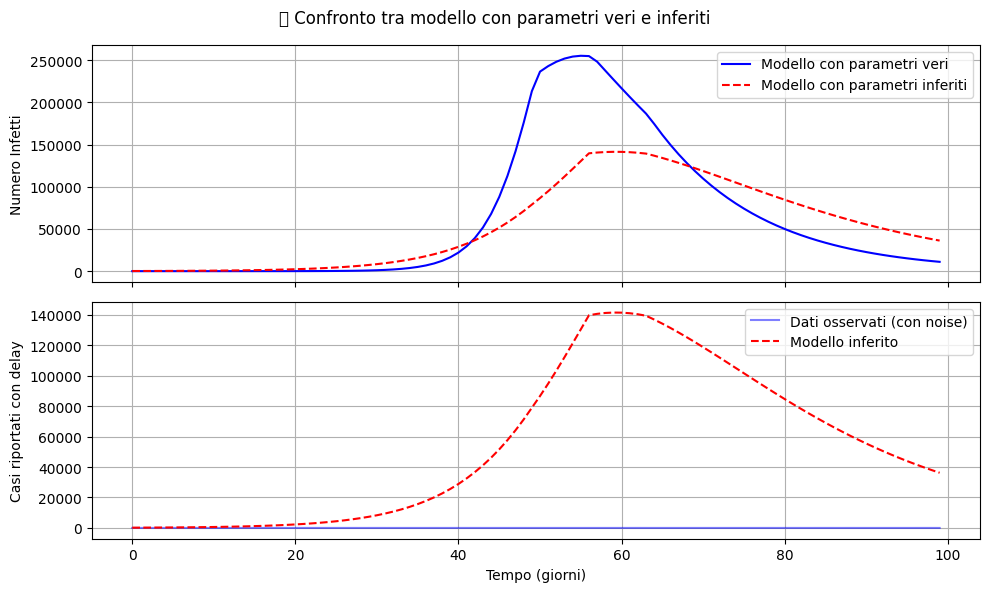

In [ ]:
summary = az.summary(trace)
print(summary.tail(15))

# SIR model with 3 switches and delay 

| Parameter          | Variable   | Prior distribution              |
|-------------------|-----------|--------------------------------|
| Change points     | \( $t_1$ \)  | Normal(2020/03/09, 3)         |
|                   | \( $t_2$ \)  | Normal(2020/03/16, 1)         |
|                   | \( $t_3$ \)  | Normal(2020/03/23, 1)         |
| Change duration   | \( $\Delta t$ \) | LogNormal(log(3), 0.3)   |
| Spreading rates   | \( $\beta_0$ \) | LogNormal(log(0.4), 0.5)  |
|                   | \( $\beta_1$ \) | LogNormal(log(0.2), 0.5)  |
|                   | \( $\beta_2$ \) | LogNormal(log(1/8), 0.5)  |
|                   | \( $\beta_3$ \) | LogNormal(log(1/16), 0.5) |
| Recovery rate     | \( $\gamma $\)  | LogNormal(log(1/8), 0.2)     |
| Reporting delay   | \( D \)  | LogNormal(log(8), 0.2)       |
| Initially infected | \( $I_0$ \)  | HalfCauchy(100)               |
| Scale factor      | \( $\sigma$ \)  | HalfCauchy(10)                |


Running chain 1/20...


C:\Users\adadi\AppData\Local\Temp\ipykernel_15408\4006628734.py:113: RuntimeWarning: overflow encountered in exp
  accept_ratio = np.exp(logp_new - logp_old)


Running chain 2/20...
Running chain 3/20...
Running chain 4/20...
Running chain 5/20...
Running chain 6/20...
Running chain 7/20...
Running chain 8/20...
Running chain 9/20...
Running chain 10/20...
Running chain 11/20...
Running chain 12/20...
Running chain 13/20...
Running chain 14/20...
Running chain 15/20...
Running chain 16/20...
Running chain 17/20...
Running chain 18/20...
Running chain 19/20...
Running chain 20/20...


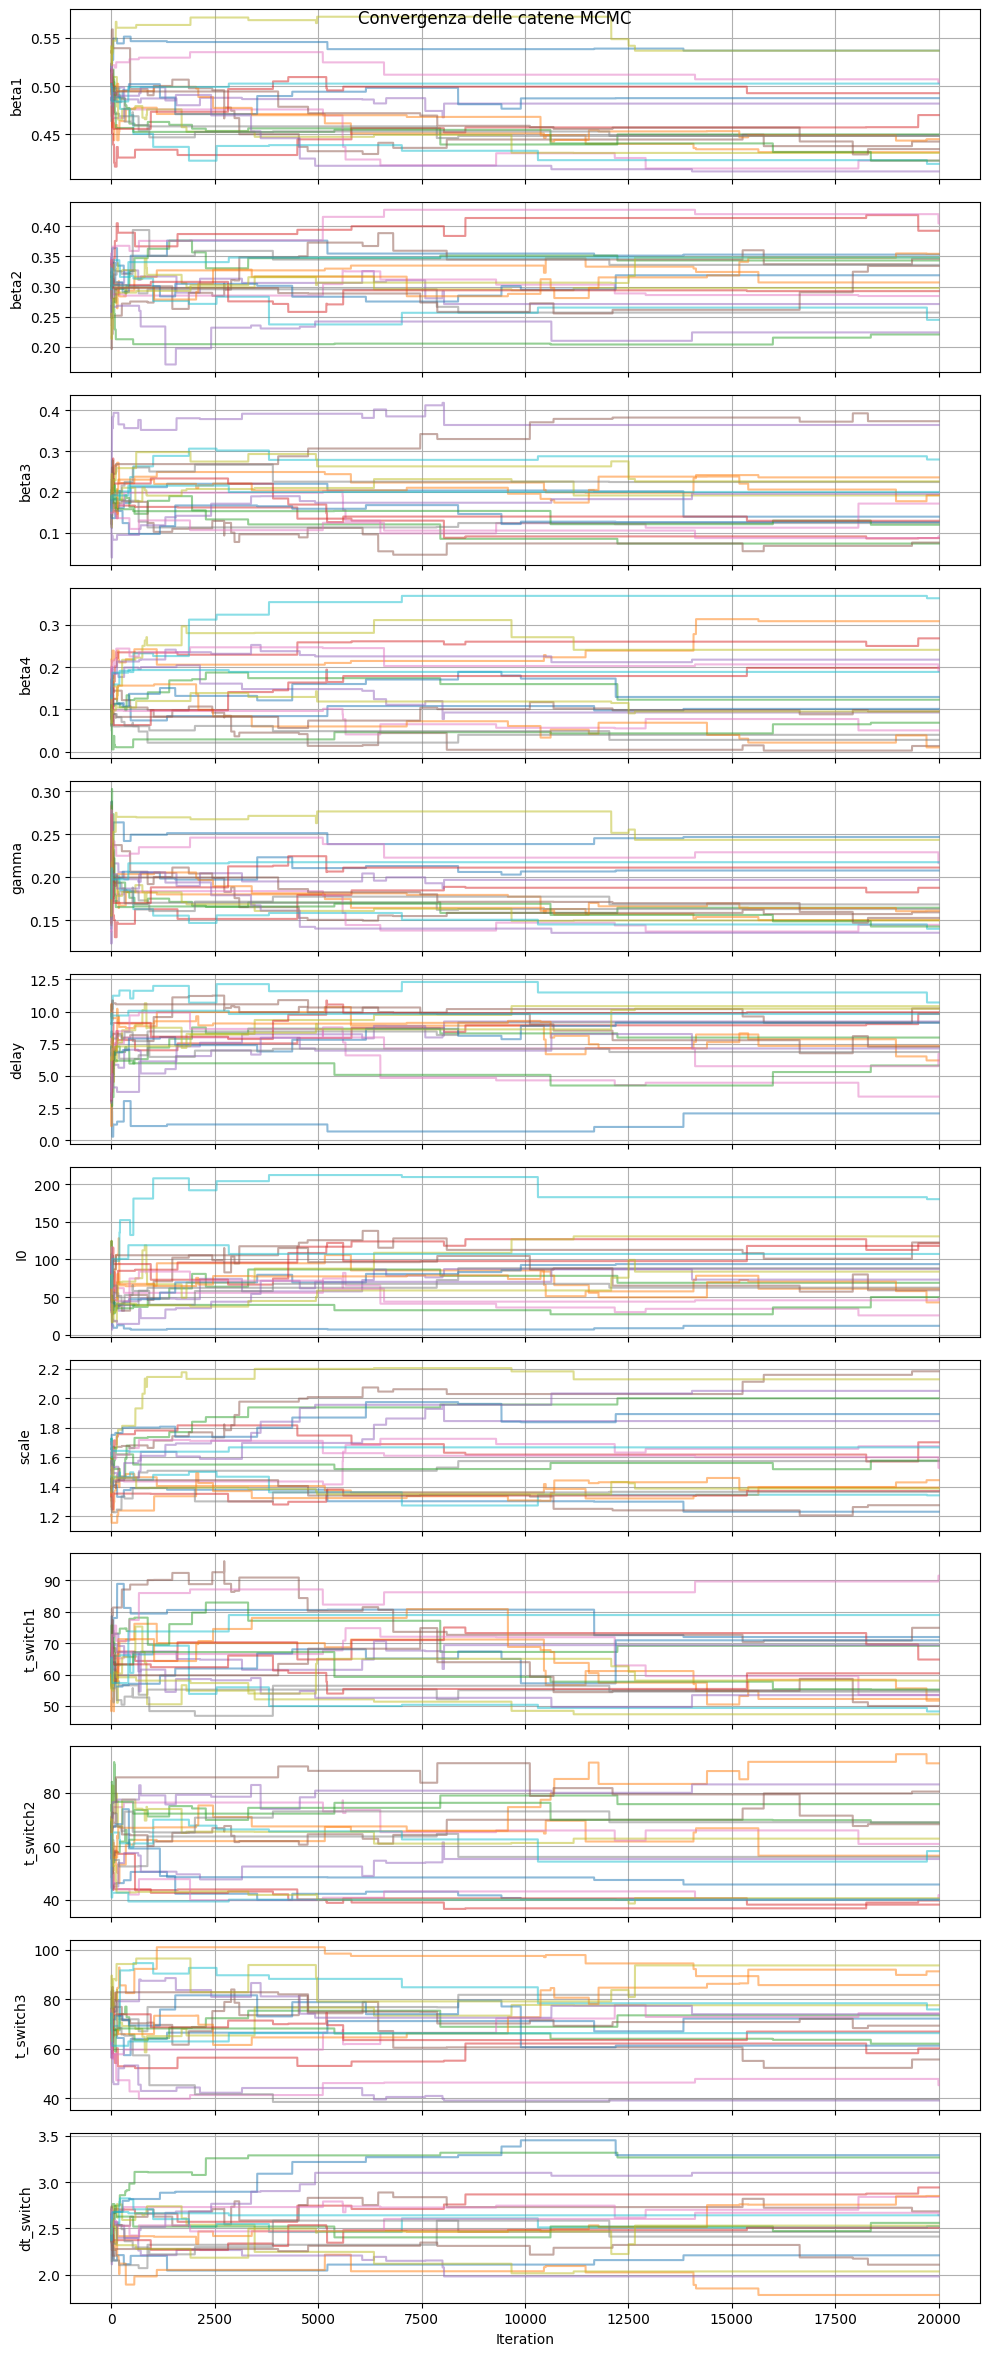

In [ ]:
from SIR_functions import sir_discrete_delay_multi_sw

# ---- PARAMETERS ----
N = 1e6  # Population size
t_max = 100  # Total days of simulation
# Priors
N = 1e6
sigma_beta, mu_beta = 0.5, np.log(0.4)
sigma_beta_2, mu_beta_2 = 0.5, np.log(0.2)
sigma_beta_3, mu_beta_3 = 0.5, np.log(1/8)
sigma_beta_4, mu_beta_4 = 0.5, np.log(1/16)
sigma_gamma, mu_gamma = 0.2, np.log(1/8)
sigma_delay, mu_delay = 0.2, np.log(8)
sigma_I0 = 100
sigma_scale = 10
sigma_time1, mu_time1 = 3, 50
sigma_time2, mu_time2 = 1, 57
sigma_time3, mu_time3 = 1, 64
sigma_dt, mu_dt = 0.3, np.log(3)

# ---- PRIOR FUNCTION ----
def log_prior(beta1, beta2, beta3, beta4, gamma, delay, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch):
    logp = (    
        stats.lognorm.logpdf(beta1, s=sigma_beta, scale=np.exp(mu_beta)) +
        stats.lognorm.logpdf(beta2, s=sigma_beta_2, scale=np.exp(mu_beta_2)) +
        stats.lognorm.logpdf(beta3, s=sigma_beta_3, scale=np.exp(mu_beta_3)) +
        stats.lognorm.logpdf(beta4, s=sigma_beta_4, scale=np.exp(mu_beta_4)) +
        stats.lognorm.logpdf(gamma, s=sigma_gamma, scale=np.exp(mu_gamma)) +
        stats.lognorm.logpdf(delay, s=0.2, scale=np.exp(np.log(8))) +
        stats.halfcauchy.logpdf(I0, scale=sigma_I0) +
        stats.halfcauchy.logpdf(scale, scale=sigma_scale) +
        stats.norm.logpdf(t_switch1, loc = mu_time1, scale = sigma_time1) +
        stats.norm.logpdf(t_switch2, loc = mu_time2, scale = sigma_time2) +
        stats.norm.logpdf(t_switch3, loc = mu_time3, scale = sigma_time3) + 
        stats.lognorm.logpdf(dt_switch, s = sigma_dt, scale = np.exp(mu_dt))
    )
    return logp

# ---- LOG-LIKELIHOOD ----
def log_likelihood(params, data):
    beta1, beta2, beta3, beta4, gamma, delay, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch = params
    I_pred, C_pred = sir_discrete_delay_multi_sw(beta1, beta2, beta3, beta4, gamma, delay, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch, t_max, N)  # Solve SIR model with delay


    # Likelihood: Assume reported cases C_t follows Normal(C_pred, scale)
    return np.sum(stats.norm.logpdf(data, loc=C_pred, scale=scale))

# ---- LOG-POSTERIOR ----
def log_posterior(params, data):
    beta1, beta2, beta3, beta4, gamma, delay, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch = params
    prior = log_prior(beta1, beta2, beta3, beta4, gamma, delay, I0, scale, t_switch1, t_switch2, t_switch3, dt_switch) 
    if np.isinf(prior) or np.isnan(prior):
        return -np.inf  # Reject invalid samples
    return prior + log_likelihood(params, data)



n_chains = 20  # Numero di catene
true_params = np.array([0.4, 0.2, 1/8, 1/16, 1/8, 8, 100, 2, 50, 57, 64, 3])

params = np.array([0.5, 0.3, 0.17, 0.12, 0.15, 6, 80, 1.5, 60, 65, 70, 2.5])

I_true, C_true = sir_discrete_delay_multi_sw(*true_params, t_max, N)  # Generate true epidemic curve
C_true += np.random.normal(0, true_params[7], size=t_max)  # Add noise

# Nuovi intervalli di generazione basati sulle migliori stime
initial_params_list = [
    params + np.random.normal(0, [0.02, 0.02, 0.01, 0.01, 0.01, 2, 2, 0.2, 0.5, 0.5, 0.5, 0.05], 12)
    for _ in range(n_chains)
]

step_sizes_list = [
    np.array([0.01, 0.02, 0.02, 0.02, 0.05, 1, 20, 0.05, 5, 5, 5, 0.1]) + np.random.uniform(-0.005, 0.005, 12)
    for _ in range(n_chains)
]

samples_all_chains = metropolis_hastings_multi_chain(log_posterior, initial_params_list, step_sizes_list, C_true, n_iter=20000, n_chains=n_chains)

fig, axes = plt.subplots(len(param_names), 1, figsize=(10, 2 * len(param_names)), sharex=True)

for i, ax in enumerate(axes):
    for chain in samples_all_chains:
        ax.plot(chain[:, i], alpha=0.5)
    ax.set_ylabel(param_names[i])
    ax.grid()

axes[-1].set_xlabel("Iteration")
plt.suptitle("Convergenza delle catene MCMC")
plt.tight_layout()
plt.show()

🔍 Parametri Verità:
  Beta1: 0.4000, Beta2: 0.2000, Beta3: 0.1250, Beta4: 0.0625, Gamma: 0.1250, delay: 8.0000, I0: 100.0, Scale: 2.0, t_switch1: 50.0,  t_switch2: 57.0,  t_switch3: 64.0, dt_switch: 3.0

🔍 Parametri Inferiti:
  beta1: 0.4608 ± 0.0373
  beta2: 0.3159 ± 0.0522
  beta3: 0.1803 ± 0.0851
  beta4: 0.1426 ± 0.0985
  gamma: 0.1784 ± 0.0349
  delay: 7.9274 ± 2.3482
  I0: 81.7875 ± 38.6484
  scale: 1.6307 ± 0.2867
  t_switch1: 61.6911 ± 11.1820
  t_switch2: 58.4588 ± 16.1757
  t_switch3: 68.2948 ± 14.7850
  dt_switch: 2.5671 ± 0.4020


C:\Users\adadi\AppData\Local\Temp\ipykernel_15408\2379254328.py:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


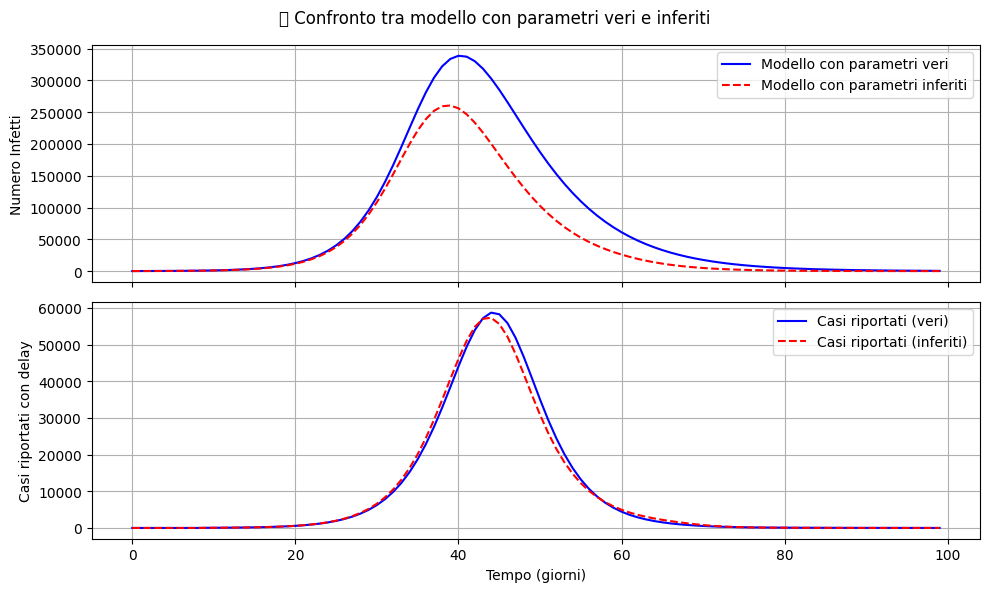

In [ ]:
param_names = ["beta1", "beta2", "beta3", "beta4", "gamma", "delay", "I0", "scale", "t_switch1", "t_switch2", "t_switch3", "dt_switch"]

burn_in = 1000
mean_estimates = np.mean(samples_all_chains[:, -burn_in:, :], axis=(0, 1))
std_estimates = np.std(samples_all_chains[:, -burn_in:, :], axis=(0, 1))

beta1_sampled, beta2_sampled, beta3_sampled, beta4_sampled, gamma_sampled, delay_sampled, I0_sampled, scale_sampled, t_switch1_sampled, t_switch2_sampled, t_switch3_sampled, dt_switch_sampled = mean_estimates

print("🔍 Parametri Verità:")
print(f"  Beta1: {true_params[0]:.4f}, Beta2: {true_params[1]:.4f}, Beta3: {true_params[2]:.4f}, Beta4: {true_params[3]:.4f}, Gamma: {true_params[4]:.4f}, delay: {true_params[5]:.4f}, I0: {true_params[6]}, Scale: {true_params[7]}, t_switch1: {true_params[8]},  t_switch2: {true_params[9]},  t_switch3: {true_params[10]}, dt_switch: {true_params[11]}")

print("\n🔍 Parametri Inferiti:")
for name, mean, std in zip(param_names, mean_estimates, std_estimates):
    print(f"  {name}: {mean:.4f} ± {std:.4f}")
    
# ---- GENERIAMO LE DUE SIMULAZIONI ----
I_true_model, C_true_model = sir_discrete_delay_multi_sw(*true_params, t_max, N)
I_sampled_model, C_sampled_model = sir_discrete_delay_multi_sw(*mean_estimates, t_max, N)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot Infected Cases
ax[0].plot(I_true_model, label="Modello con parametri veri", color="blue")
ax[0].plot(I_sampled_model, label="Modello con parametri inferiti", color="red", linestyle="dashed")
ax[0].set_ylabel("Numero Infetti")
ax[0].legend()
ax[0].grid()

# Plot Reported Cases (con delay)
ax[1].plot(C_true_model, label="Casi riportati (veri)", color="blue")
ax[1].plot(C_sampled_model, label="Casi riportati (inferiti)", color="red", linestyle="dashed")
ax[1].set_ylabel("Casi riportati con delay")
ax[1].set_xlabel("Tempo (giorni)")
ax[1].legend()
ax[1].grid()

fig.suptitle("📊 Confronto tra modello con parametri veri e inferiti")
plt.tight_layout()
plt.show()


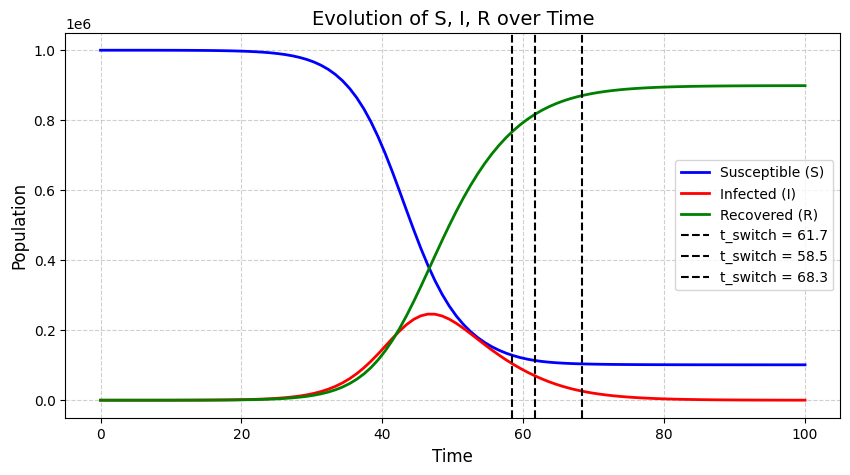

In [60]:
# Basic sir model, just for the plot 
def sir_model(y, t, beta1, beta2, beta3, beta4, gamma, delay, t_switch1, t_switch2, t_switch3, dt_switch, N, I_sampled_model):
    S, I, R = y
        # Smooth transitions between beta values   
    transition1 = 1 / (1 + np.exp(-(t - t_switch1) / dt_switch))
    transition2 = 1 / (1 + np.exp(-(t - t_switch2) / dt_switch))
    transition3 = 1 / (1 + np.exp(-(t - t_switch3) / dt_switch))

        # Weighted combination of beta values
    beta = (beta1 * (1 - transition1) + 
            beta2 * (transition1 * (1 - transition2)) + 
            beta3 * (transition2 * (1 - transition3)) + 
            beta4 * transition3)
    
    if int(t - delay) >= 0:  # Assicurati che t - delay sia un indice valido
        I_past = I_sampled_model[int(t - delay)]  # Infezioni avvenute 'delay' giorni fa
    else:
        I_past = 0  # Se t - delay è negativo, considera che non ci sono infezioni passate
    
    # Calcolare le derivate
    dSdt = -beta * S * I_past / N  # Nuove infezioni dipendono dalle infezioni ritardate
    dIdt = beta * S * I_past / N - gamma * I  # Infezioni e recupero
    dRdt = gamma * I  # Recuperi
    
    return [dSdt, dIdt, dRdt]  # Non è più necessario restituire I_past_array

# ---- SOLVE SIR MODEL USING ESTIMATED PARAMETERS ----
S0_est = N - I0_sampled
y0_est = [S0_est, I0_sampled, 0]  # Initial conditions

sol_est = odeint(sir_model, y0_est, t, args=(beta1_sampled, beta2_sampled, beta3_sampled, beta4_sampled, 
                                             gamma_sampled, delay_sampled, t_switch1_sampled, 
                                             t_switch2_sampled, t_switch3_sampled, dt_switch_sampled, N, I_sampled_model))

S_est, I_est, R_est = sol_est[:, 0], sol_est[:, 1], sol_est[:, 2]

# ---- PLOT THE EVOLUTION OF S, I, R ----

plt.figure(figsize=(10, 5))

# Traccia le curve per S, I, R
plt.plot(t, S_est, label="Susceptible (S)", color="blue", linewidth=2)
plt.plot(t, I_est, label="Infected (I)", color="red", linewidth=2)
plt.plot(t, R_est, label="Recovered (R)", color="green", linewidth=2)

# Linea verticale per t_switch
plt.axvline(x=t_switch1_sampled, color="black", linestyle="dashed", linewidth=1.5, label=f"t_switch = {t_switch1_sampled:.1f}")
plt.axvline(x=t_switch2_sampled, color="black", linestyle="dashed", linewidth=1.5, label=f"t_switch = {t_switch2_sampled:.1f}")
plt.axvline(x=t_switch3_sampled, color="black", linestyle="dashed", linewidth=1.5, label=f"t_switch = {t_switch3_sampled:.1f}")



# Miglioramenti estetici
plt.xlabel("Time", fontsize=12)
plt.ylabel("Population", fontsize=12)
plt.title("Evolution of S, I, R over Time", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Mostra il grafico
plt.show()

Initializing NUTS using jitter+adapt_diag...
c:\ProgramData\anaconda3\lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta2, beta3, beta4, gamma, delay, I0, scale]


C:\Users\adadi\AppData\Roaming\Python\Python310\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 2_000 tune and 2_689 draw iterations (4_000 + 5_378 draws total) took 52002 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


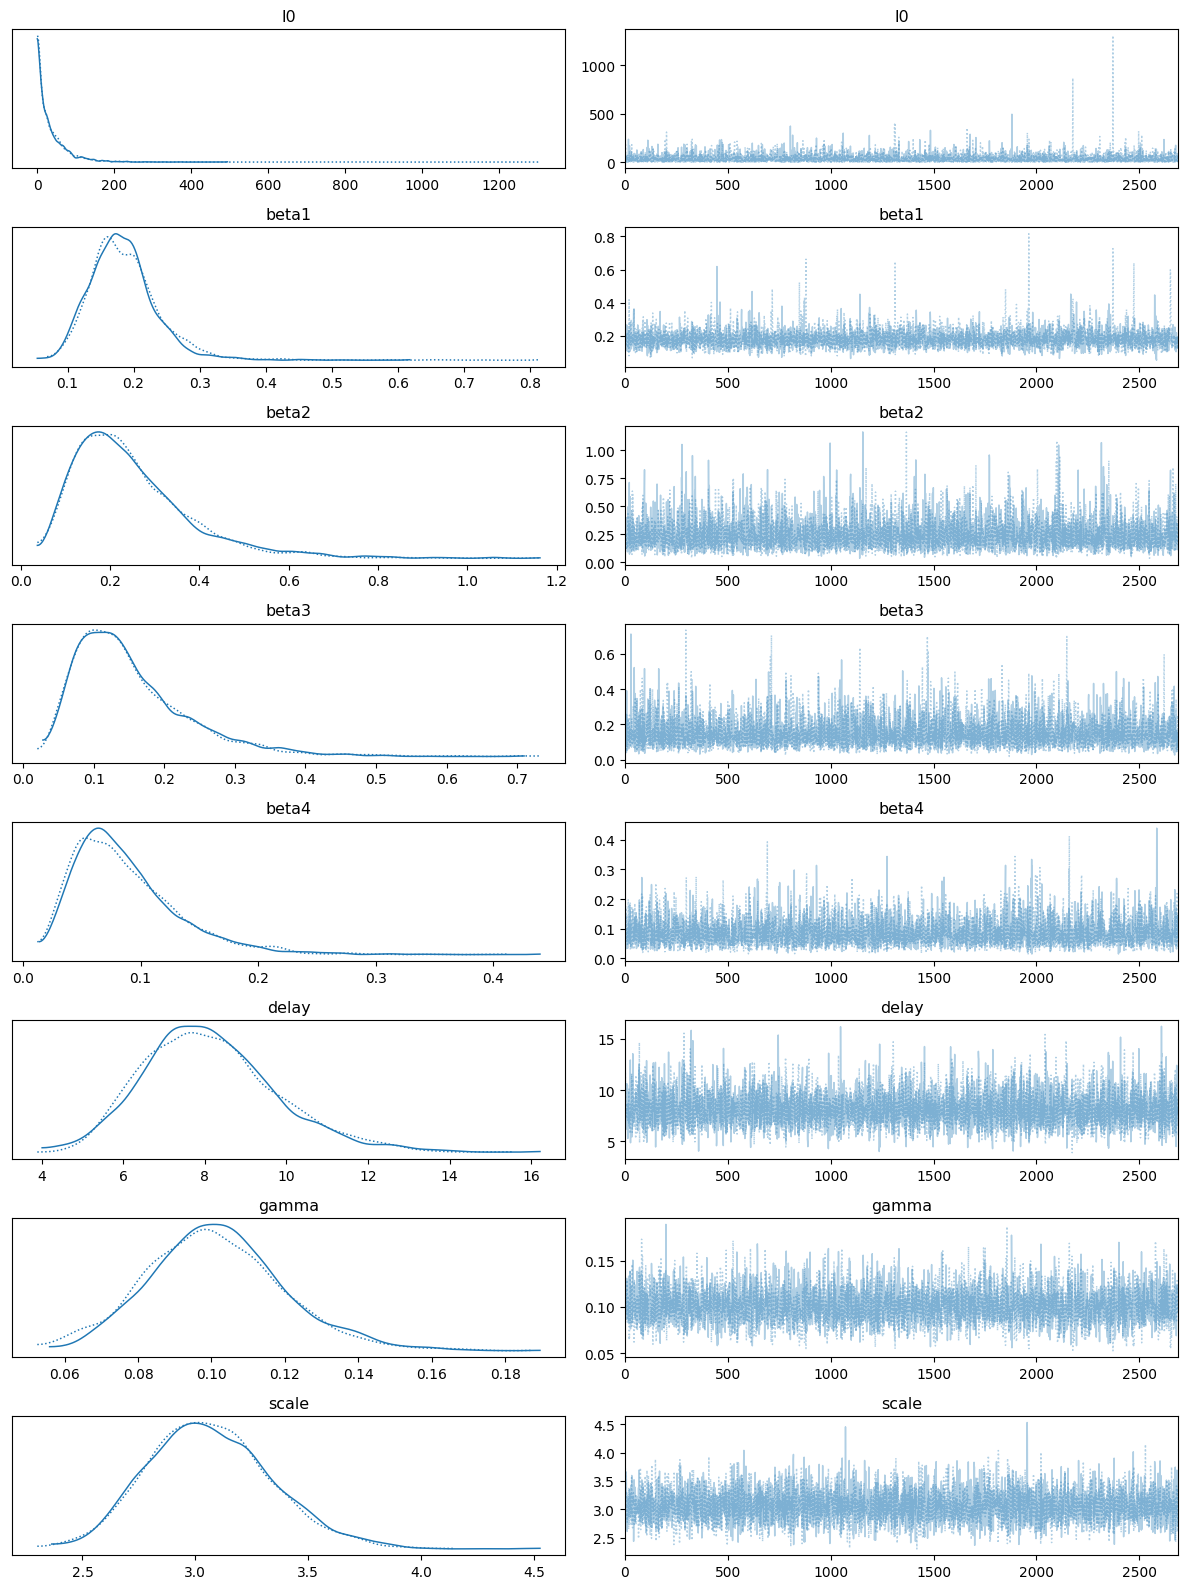

In [ ]:
# SIR model with 3 switches and delay 
from SIR_functions import smooth_step_function, pt_lognormal, make_delay_matrix, apply_delay, delay_cases_lognormal, _SIR_model



# ---- SIMULAZIONE DATI ----
true_params = {"beta1": 0.4, "beta2": 0.2, "beta3": 1/8, "beta4": 1/16, "gamma": 1/8, "I0": 100, "scale": 10, "delay": 8, "scale_delay": 0.5}
N = 1e6
t_max = 100
S = N - true_params["I0"]
t = np.linspace(0, 100, 100)
lambda_list = [0.4, 0.2, 1/8, 1/16]
num_days_sim = 100
tr_begin_list = [50, 56, 64]
tr_len_list = [3, 1, 1]
# SIR deterministico

# --------------------------------------------------------------------------------------------
    # build the time-dependent spreading rate
lambda_t_list = [lambda_list[0] * pt.ones(num_days_sim)]
lambda_before = lambda_list[0]
for tr_begin, tr_len, lambda_after in zip(
    tr_begin_list, tr_len_list, lambda_list[1:]
):
    lambda_t = smooth_step_function(
        start_val=0,
        end_val=1,
        t_begin=tr_begin,
        t_end=tr_begin + tr_len,
        t_total=num_days_sim,
    ) * (lambda_after - lambda_before)
    lambda_before = lambda_after
    lambda_t_list.append(lambda_t)

lambda_t = sum(lambda_t_list)
lambda_t = lambda_t.astype("float64")
# ----------------------------------------------------------------------------------------------

S = np.float64(S)
N = np.float64(N)  # Se è un intero, lo converto esplicitamente a float
I0 = np.float64(true_params["I0"])
mu = np.float64(true_params["gamma"])
_, _, I_new_true = _SIR_model(lambda_t, mu, S, I0, N)

f = pytensor.function([], [I_new_true])
I_new_true = f()[0]

# Rumore osservativo t-Student
lognorm_kernel_sim = stats.lognorm.pdf(make_delay_matrix(t_max, t_max), s=true_params["scale_delay"], scale=true_params["delay"])
lognorm_kernel_sim /= lognorm_kernel_sim.sum(axis=1, keepdims=True)
C_obs = np.dot(I_new_true, lognorm_kernel_sim)

# Rumore osservativo t-Student
C_obs += stats.t.rvs(df=4, loc=0, scale=true_params["scale"], size=len(C_obs))

date_begin_simulation = datetime(2020, 3, 9)
change_points_list = [50] # changing point at day 50 

# Lista contenente soltanto i change points 
change_points_list = [
    {
        "pr_mean_date_begin_transient": datetime(2020, 3, 9) + timedelta(days=50),  # Giorno 50 dalla data iniziale
        "pr_median_lambda": 0.2,  # λ₀ valore di default dalla tabella
        "pr_sigma_lambda": 0.5,  # σ per log-normal di λ₀
        "pr_sigma_date_begin_transient": 3,  # Default
        "pr_median_transient_len": 3,  # Default
        "pr_sigma_transient_len": 0.3,  # Default
    },
    {
        "pr_mean_date_begin_transient": datetime(2020, 3, 9) + timedelta(days=56),  # Giorno 50 dalla data iniziale
        "pr_median_lambda": 1/8,  # λ₀ valore di default dalla tabella
        "pr_sigma_lambda": 0.5,  # σ per log-normal di λ₀
        "pr_sigma_date_begin_transient": 1,  # Default
        "pr_median_transient_len": 3,  # Default
        "pr_sigma_transient_len": 0.3,  # Default
    },
    {
        "pr_mean_date_begin_transient": datetime(2020, 3, 9) + timedelta(days=64),  # Giorno 50 dalla data iniziale
        "pr_median_lambda": 1/16,  # λ₀ valore di default dalla tabella
        "pr_sigma_lambda": 0.5,  # σ per log-normal di λ₀
        "pr_sigma_date_begin_transient": 1,  # Default
        "pr_median_transient_len": 3,  # Default
        "pr_sigma_transient_len": 0.3,  # Default
    },
]

# ---- MODELLO BAYESIANO PyMC ----
with pm.Model() as model:
    beta1 = pm.Lognormal("beta1", mu=np.log(0.4), sigma=0.5)
    beta2 = pm.Lognormal("beta2", mu = np.log(0.2), sigma = 0.5)
    beta3 = pm.Lognormal("beta3", mu = np.log(1/8), sigma = 0.5)
    beta4 = pm.Lognormal("beta4", mu = np.log(1/16), sigma = 0.5)

    lambda_list = [beta1, beta2, beta3, beta4]

    # list of start dates of the transient periods of the change points
    tr_begin_list = []
    dt_before = date_begin_simulation
    for i, cp in enumerate(change_points_list):
        dt_begin_transient = cp["pr_mean_date_begin_transient"]
        if dt_before is not None and dt_before > dt_begin_transient:
            raise RuntimeError("Dates of change points are not temporally ordered")
        prior_mean = (
            dt_begin_transient - date_begin_simulation).days - 1  # convert the provided date format (argument) into days (a number)
        tr_begin = pm.Normal(
            name=f"transient_begin_{i}",
            mu=prior_mean,
            sigma=cp["pr_sigma_date_begin_transient"],
        )
        tr_begin_list.append(tr_begin)
        dt_before = dt_begin_transient
    # same for transient times
    tr_len_list = []
    for i, cp in enumerate(change_points_list):
        tr_len = pm.Lognormal(
            name=f"transient_len_{i}",
            mu=np.log(cp["pr_median_transient_len"]),
            sigma=cp["pr_sigma_transient_len"],
        )
        tr_len_list.append(tr_len)
    # build the time-dependent spreading rate
    lambda_t_list = [lambda_list[0] * pt.ones(num_days_sim)]
    lambda_before = lambda_list[0]

    for tr_begin, tr_len, lambda_after in zip(
        tr_begin_list, tr_len_list, lambda_list[1:]
    ):
        lambda_t = smooth_step_function(
            start_val=0,
            end_val=1,
            t_begin=tr_begin,
            t_end=tr_begin + tr_len,
            t_total=num_days_sim,
        ) * (lambda_after - lambda_before)
        lambda_before = lambda_after
        lambda_t_list.append(lambda_t)
    lambda_t = sum(lambda_t_list)
    
    gamma = pm.Lognormal("gamma", mu=np.log(1/8), sigma=0.2)
    I0 = pm.HalfCauchy("I0", beta=100)
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.5)
    scale_delay = pm.HalfNormal("scale_delay", sigma=1)
    scale = pm.HalfCauchy("scale", beta=10)

    S_begin = N - I0
    S, I, new_I = _SIR_model(
        lambda_t=lambda_t, mu=gamma, S_begin=S_begin, I_begin=I0, N=N
    )
    C_pred = pm.Deterministic("C_pred", delay_cases_lognormal(new_I, t_max, t_max, delay, scale_delay))

    num_days_data = C_pred.shape[-1]
    pm.StudentT("obs",
                 nu=4,
                 mu=C_pred[:num_days_data],
                 sigma= scale, 
                 observed=C_obs)

    trace = pm.sample(2000, tune=500, cores=4, chains=4, target_accept=0.85)



az.plot_trace(trace)
plt.tight_layout()
plt.show()


In [ ]:
summary = az.summary(trace)
print(summary.tail(15))

NameError: name 'trace' is not defined